In [1]:
## Pima Indians Diabetes Database
### Comparison of resampling mechanisms.

### Import the required libraries.

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import fbeta_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

from scipy import stats
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
from kmodes.kmodes import KModes
from minisom import MiniSom

from imblearn import FunctionSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from smote_variants import SUNDO
from sklearn.utils import Bunch
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import scipy.linalg as la
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

### Load the dataset to use for this analysis.

In [3]:
# Load the data file and see what it looks like.
data_path = "/Volumes/Scratch/pima/diabetes.csv"
df = pd.read_csv(data_path, header=0)

### Emit some basic information to get a sense of what the data look like.

In [4]:
print(df.shape)
df.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
df.Outcome.value_counts(normalize = True)

Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64

### This dataset uses zeros in features where that value doesn't make senses to representing missing data. Replace those with explicit 'missing' values and see what is there.

In [7]:
nz_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[nz_cols] = df[nz_cols].replace(0, np.nan)
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

### We have 768 rows. 374 (49%) are missing an Insulin value and 227 (30%) are missing SkinThickness. Let's see how much predictive power those two are likely to have.

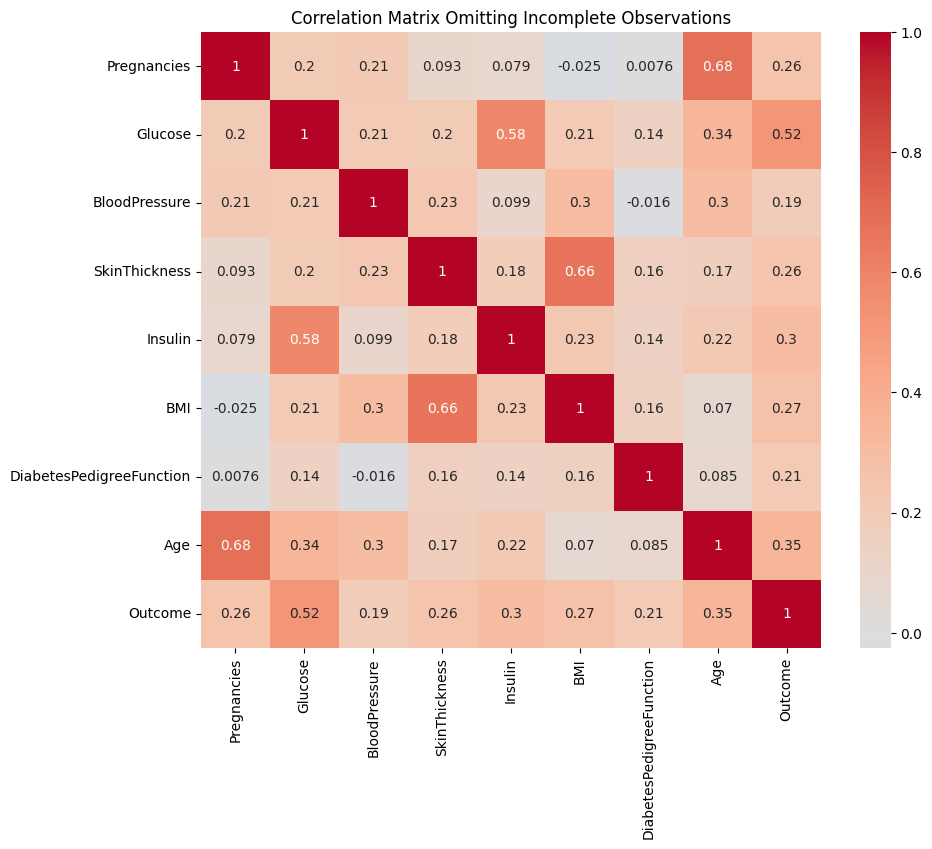

In [8]:
plt.figure(figsize = (10, 8))
corr_map = sns.heatmap(df.dropna().corr(), cmap = 'coolwarm', center = 0, annot = True)
corr_map.set_title('Correlation Matrix Omitting Incomplete Observations')
plt.savefig('pima-corr-full.png', bbox_inches = 'tight')
plt.show()

### As individual predictors SkinThickness and Insulin are both middle-of-the pack. If they were very poor it would be tempting to just ignore those attributes and carry on, but this is a more challenging call. Let's run a very simple test to compare the results. For this step we'll be using a model that has been tailored to deal with imbalanced data.

In [9]:
df_aggressive = df.dropna()
df_cautious = df.drop(['SkinThickness', 'Insulin'], axis = 1).dropna()
print(f"Aggressively cleaned: {df_aggressive.shape}")
print(f"Cautiously cleaned: {df_cautious.shape}")

Aggressively cleaned: (392, 9)
Cautiously cleaned: (724, 7)


### First let's see how we do after dropping every record with missing values.

Outcome
0    0.666667
1    0.333333
Name: proportion, dtype: float64
Outcome
0    0.673469
1    0.326531
Name: proportion, dtype: float64
[0.07274273 0.2443819  0.07824069 0.08736162 0.19403543 0.1156503
 0.08760422 0.11998311]
F-score: 0.6626506024096386


<Figure size 1000x800 with 0 Axes>

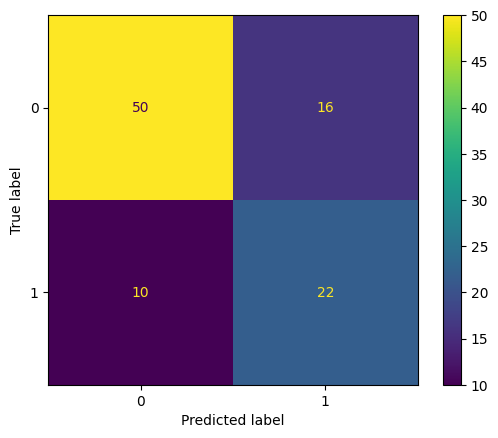

<Figure size 1000x800 with 0 Axes>

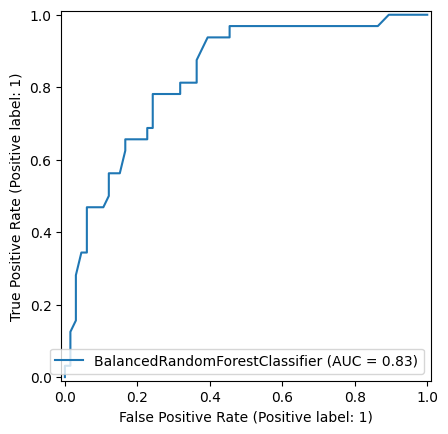

In [10]:
X = df_aggressive.drop('Outcome', axis = 1)
y = df_aggressive['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))
model = BalancedRandomForestClassifier()
scaler = MinMaxScaler()

model.fit(scaler.fit_transform(X_train), y_train)
print(model.feature_importances_)
y_test_pred = model.predict(scaler.transform(X_test))

print(f"F-score: {fbeta_score(y_test, y_test_pred, beta = 2)}")

plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.savefig('final-pima-aggressive-conf.png');
plt.show()
plt.figure(figsize=(10, 8))
RocCurveDisplay.from_estimator(model, scaler.transform(X_test), y_test)
plt.savefig('final-pima-aggressive-roc.png');
plt.show()

### And now the same process on the data when we ignore the largely empty columns.

Outcome
0    0.642726
1    0.357274
Name: proportion, dtype: float64
Outcome
0    0.696133
1    0.303867
Name: proportion, dtype: float64
[0.08517021 0.31666955 0.09147356 0.2016995  0.14636938 0.1586178 ]
F-score: 0.7017543859649122


<Figure size 1000x800 with 0 Axes>

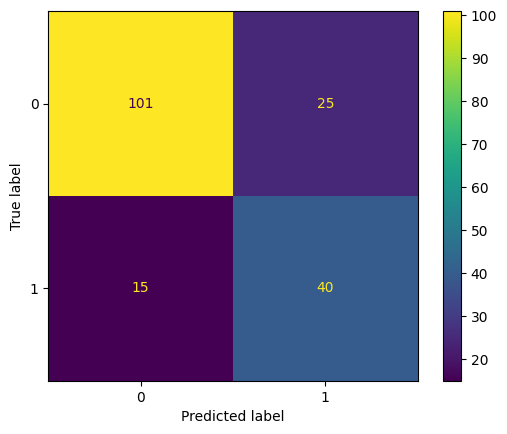

<Figure size 1000x800 with 0 Axes>

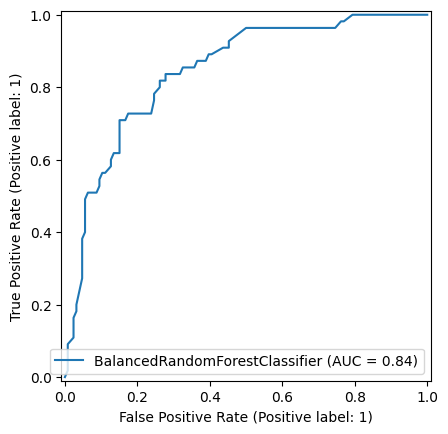

In [11]:
X = df_cautious.drop('Outcome', axis = 1)
y = df_cautious['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))
model = BalancedRandomForestClassifier()
scaler = MinMaxScaler()

model.fit(scaler.fit_transform(X_train), y_train)
print(model.feature_importances_)
y_test_pred = model.predict(scaler.transform(X_test))

print(f"F-score: {fbeta_score(y_test, y_test_pred, beta = 2)}")

plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.savefig('final-pima-cautious-conf.png');
plt.show()
plt.figure(figsize=(10, 8))
RocCurveDisplay.from_estimator(model, scaler.transform(X_test), y_test)
plt.savefig('final-pima-cautious-roc.png');
plt.show()

### So it looks like we did better dropping those two columns. AUC and F-score both improved a fair amount. It's kind of interesting that the model trained on the aggressively cleaned data ended up considering Insulin as the second-most important feature even though it was noticeably behind Age in the single-feature correlation matrix. So we'll use df_cautious from here on out.

In [12]:
# Technically we do not need to do this because this was the last test case, but for clarity we run it again.
X = df_cautious.drop('Outcome', axis = 1)
y = df_cautious['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

Outcome
0    0.642726
1    0.357274
Name: proportion, dtype: float64
Outcome
0    0.696133
1    0.303867
Name: proportion, dtype: float64


### Now the fun begins. We're going to attempt to implement proposed resampling methods.

In [13]:
def denoise(X, y, n_neighbors = 3):
    """
    Given a set of predictors and targets, determines which class is the minority and then looks for members
    of the minority class for which the closest neighbors are all in the majority. Those elements will be
    pruned from the set.
    """
    # Identify the classes and how many of each exist.
    classes, class_counts = np.unique(y, return_counts = True)
    print(f"Classes: {classes}")

    # Determine which class has the lowest representation in the dataset.
    minority_index = np.argmin(class_counts)
    minority_class = classes[minority_index]
    print(f"Minority Class: {minority_class}")
    print(f"Minority Ratio: {class_counts[minority_index] / y.size}")

    # Build a model representing the nearest neighbors and set up a list to cache the points that are noise.
    knn = NearestNeighbors(n_neighbors = n_neighbors + 1).fit(X)
    noise = []
    
    # Identify which data points represent the minority.
    minority_indices = np.where(y == minority_class)

    # Get the indices of the closest neighbors for each minority sample and then loop over the collection.
    ind = knn.kneighbors(X[minority_indices], return_distance = False)
    for test_index in np.arange(len(ind)):
        # Ignore the closest neighbor because that's the point itself.
        neighbor_indices = ind[test_index][1:]

        # Check for all of the others to _not_ be in the minority class and add to the noise list if that's the case.
        if np.all([y[i] != minority_class for i in neighbor_indices]):
            noise.append(test_index)

    print(f"Noisy samples: {np.array(noise)}")
    return np.delete(X, noise, axis = 0), np.delete(y, noise, axis = 0)

def get_category_indices(X, y, n_neighbors = 3):
    """
    Determine and return the sets of indices representing the minority, the boundary majority, and the remaining majority.
    """
    # Identify the classes and how many of each exist.
    classes, class_counts = np.unique(y, return_counts = True)
    print(f"Classes: {classes}")

    # Determine which class has the lowest representation in the dataset.
    minority_index = np.argmin(class_counts)
    minority_class = classes[minority_index]
    print(f"Minority Class: {minority_class}")
    print(f"Minority Ratio: {class_counts[minority_index] / y.size}")

    # Build a model representing the nearest neighbors and set up a list to cache the points that are noise.
    knn = NearestNeighbors(n_neighbors = n_neighbors + 1).fit(X)

    # Get the minority indices ... that's the easy one.
    minority_indices = np.where(y == minority_class)
    
    bmaj = []
    obmaj = []
    majority_indices = np.where(y != minority_class)

    # Get the indices of the closest neighbors for each majority sample and then loop over the collection.
    ind = knn.kneighbors(X, return_distance = False)
    print(ind)
    for test_index in majority_indices[0]:
        # Ignore the closest neighbor because that's the point itself.
        neighbor_indices = ind[test_index][1:]
        if np.any([y[i] == minority_class for i in neighbor_indices]):
            bmaj.append(test_index)
        else:
            obmaj.append(test_index)

    return minority_indices[0], np.array(bmaj), np.array(obmaj)

def sort_majority_samples(X):
    """
    Given a set of samples, return a list of indices into that collection sorted by descending distance to closest neighbor.
    """
    p = len(X[0])
    n = len(X)
    mat = np.zeros((n, n))
    for row in np.arange(n):
        for col in np.arange(n):
            if col == row:
                continue
            sum = np.zeros((p, p))
            for i in np.arange(n):
                q = X[i] - X[col]
                sum += np.outer(q, q)
            S_j = (1.0 / (n - 1)) * sum
            x = X[row] - X[col]
            mat[row, col] = (1.0 / p) * np.abs(np.dot(np.dot(x, np.linalg.inv(S_j)), x))

    # Now the distance between observations i and j is the minimum of mat[i,j] and mat[j,i]
    # For each entry we want to find the distance to its closest neighbor.
    pairs = []
    for obs in np.arange(n):
        row_vals = np.delete(mat[obs, :], obs)
        col_vals = np.delete(mat[:, obs], obs)
        pairs.append([obs, np.min(np.append(row_vals, col_vals))])
    nearest = np.array(pairs)
    sorted_indices = nearest[:, 1].argsort()[::-1]
    return sorted_indices

def anis_ali(X, y, random_state = 0):
    X_quiet, y_quiet = denoise(X, y)
    minority_indices, boundary_indices, majority_indices = get_category_indices(X_quiet, y_quiet)

    X_minority = X_quiet[minority_indices]
    y_minority = y_quiet[minority_indices]

    X_majority = X_quiet[majority_indices]
    y_majority = y_quiet[majority_indices]
    sorted_majority = sort_majority_samples(X_majority)

    X_resampled = np.append(X_minority, X_majority[:len(X_minority)], axis=0)
    y_resampled = np.append(y_minority, y_majority[:len(y_minority)], axis=0)
    return X_resampled, y_resampled

In [14]:
def relabel_clusters(labels, reference_labels, label_count):
    cost_matrix = np.zeros((len(np.unique(labels)), len(np.unique(reference_labels))))
    for i, l1 in enumerate(np.unique(labels)):
        for j, l2 in enumerate(np.unique(reference_labels)):
            cost_matrix[i, j] = -np.sum((labels == l1) & (reference_labels == l2))

    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    mapping = {old_label:new_label for old_label, new_label in zip(np.unique(labels)[row_ind], np.unique(reference_labels)[col_ind])}
    mapped_labels = np.array([mapping[label] for label in labels])
    return mapped_labels
    
def onan(X, y, random_state = 0):
    majority_indices = np.where(y == 0)[0] # Assuming false is the majority class.
    minority_indices = np.where(y == 1)[0] # Assuming true is the minority class.
    n = len(majority_indices)
    m = len(minority_indices)
    num_clusters = m
    print(num_clusters)

    majority_predictors = X[majority_indices]

    cluster1 = KMeans(n_clusters = m, init = 'random', random_state = random_state)
    cluster2 = KModes(n_clusters = m, random_state = random_state)
    cluster3 = KMeans(n_clusters = m, random_state = random_state)
    cluster4 = MiniSom(m, 1, X.shape[1])
    cluster4.random_weights_init(X)
    cluster5 = AgglomerativeClustering(n_clusters = m, linkage = 'single')

    cluster1.fit(majority_predictors)
    cluster2.fit(majority_predictors)
    cluster3.fit(majority_predictors)
    cluster4.train_batch(majority_predictors, 5000)
    cluster5.fit(majority_predictors)

    part1 = cluster1.labels_
    part2 = relabel_clusters(cluster2.labels_, part1, num_clusters)
    part3 = relabel_clusters(cluster3.labels_, part1, num_clusters)
    part4 = relabel_clusters(np.array([int(cluster4.winner(x)[0]) for x in majority_predictors]), part1, num_clusters)
    part5 = relabel_clusters(cluster5.labels_, part1, num_clusters)

    all_parts = np.row_stack((part1, part2, part3, part4, part5))
    consensus_parts = stats.mode(all_parts).mode
    augmented = np.column_stack((majority_predictors, consensus_parts))
    maj_frame = pd.DataFrame(augmented)
    maj_means = maj_frame.groupby(maj_frame.columns[-1]).mean()

    # It's likely that in the course of consensus building we may lose some clusters, so pad it from the original data.
    supp_indices = np.random.choice(range(majority_predictors.shape[0]), max(0, m - maj_means.shape[0]), replace = False)

    X_new = np.row_stack((X[minority_indices], maj_means.to_numpy(), majority_predictors[supp_indices]))
    y_new = np.array([1] * m + [0] * maj_means.shape[0] + [0] * supp_indices.shape[0])
    
    return X_new, y_new

In [15]:
# Helper function to compute G-mean
def g_mean(y_true, y_pred):
    from sklearn.metrics import recall_score
    sensitivity = recall_score(y_true, y_pred, pos_label=1)
    specificity = recall_score(y_true, y_pred, pos_label=0)
    return np.sqrt(sensitivity * specificity)

# Helper function to compute AUC-PR
def auc_pr(y_true, y_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    return auc(recall, precision)

# Function to compute IR ratio
def compute_ir_ratio(y):
    counts = np.bincount(y.astype(int))
    if len(counts) < 2:  # Ensure both classes are present
        return float('inf') if counts[0] > 0 else 0
    majority = max(counts)
    minority = min(counts)
    return majority / minority if minority > 0 else float('inf')

# Fisher Information Matrix (Equation 4)
def fisher_information(X, beta, lambda_reg):
    probs = 1 / (1 + np.exp(-X @ beta))
    W = np.diag(probs * (1 - probs))
    I = X.T @ W @ X + lambda_reg * np.eye(X.shape[1])
    return I

# MSEE computation (Equation 7)
def compute_msee(X_j, X_i, beta, lambda_reg, S_X, S_y):
    # Update Fisher information with X_i
    X_S = np.vstack([S_X, X_i])
    I_S_xi = fisher_information(X_S, beta, lambda_reg)
    I_inv = la.inv(I_S_xi)
    
    # Predicted probabilities
    pi_j = 1 / (1 + np.exp(-X_j @ beta))
    
    # Bias term
    bias_term = -pi_j * (1 - pi_j) * (X_j @ (lambda_reg * I_inv @ beta))
    
    # Variance term
    var_term = (pi_j * (1 - pi_j))**2 * (X_j @ I_inv @ (I_S_xi - lambda_reg * np.eye(X_S.shape[1])) @ I_inv.T @ X_j)
    
    return (bias_term**2 + var_term)

# Here we are... Main Active Downsampling Algorithm
def lee_seo(X, y, l=2, k=200, lambda_reg=1.0, epsilon=0.1, C_size=10, random_state=0):
    # Standardize the features
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    X_std[X_std == 0] = 1  # Avoid division by zero
    X_scaled = (X - X_mean) / X_std

    # (1) Initialize training, pool, and test sets
    n_samples = X_scaled.shape[0]
    indices = np.arange(n_samples)
    
    # Ensure balanced initial training set (l instances per class)
    pos_indices = indices[y == 1]
    neg_indices = indices[y == 0]
    if len(pos_indices) < l or len(neg_indices) < l:
        raise ValueError(f"Not enough instances to select {l} per class. Pos: {len(pos_indices)}, Neg: {len(neg_indices)}")
    pos_indices = pos_indices[:l]
    neg_indices = neg_indices[:l]
    train_indices = np.concatenate([pos_indices, neg_indices])
    S_indices = train_indices
    SC_indices = np.setdiff1d(indices, S_indices)
    
    S_X, S_y = X_scaled[S_indices], y[S_indices]
    SC_X, SC_y = X_scaled[SC_indices], y[SC_indices]
    
    # (2). Iterative selection
    for n in range(k):
        if len(SC_X) < C_size:
            print(f"Pool set too small at iteration {n}. Stopping early.")
            break
            
        # Calculate cost weights (inversely proportional to class frequencies)
        S_pos = np.sum(S_y == 1)
        S_neg = np.sum(S_y == 0)
        c01 = 1 / S_pos if S_pos > 0 else 1
        c10 = 1 / S_neg if S_neg > 0 else 1
        sample_weight = np.where(S_y == 1, c01, c10)
        
        # Estimate parameters (Equation 2) using penalized logistic regression
        model = LogisticRegression(penalty='l2', C=1/lambda_reg, fit_intercept=True, solver='lbfgs', max_iter=1000)
        model.fit(S_X, S_y, sample_weight=sample_weight)
        
        # Extract beta (coefficients and intercept)
        beta = np.concatenate([model.intercept_, model.coef_[0]])
        S_X_with_intercept = np.hstack([np.ones((S_X.shape[0], 1)), S_X])
        SC_X_with_intercept = np.hstack([np.ones((SC_X.shape[0], 1)), SC_X])
        
        # Pre-select candidates (Equation 8)
        probs = model.predict_proba(SC_X)[:, 1]
        uncertainty = np.abs(probs - (1 - probs))
        C_indices = np.argsort(uncertainty)[:min(C_size, len(uncertainty))]
        C_X = SC_X[C_indices]
        C_X_with_intercept = SC_X_with_intercept[C_indices]
        
        # Compute average MSEE for each candidate (Equation 9)
        avg_msee = []
        for i in range(len(C_indices)):
            msee = 0
            for j in range(len(SC_X)):
                msee += compute_msee(SC_X_with_intercept[j], C_X_with_intercept[i], beta, lambda_reg, S_X_with_intercept, S_y)
            avg_msee.append(msee / len(SC_X))
        
        # Select the most informative instance
        best_idx = np.argmin(avg_msee)
        S_indices = np.append(S_indices, best_idx)
        x_star = C_X[best_idx]
        y_star = SC_y[C_indices[best_idx]]
        
        # Update training and pool sets
        S_X = np.vstack([S_X, x_star])
        S_y = np.append(S_y, y_star)
        SC_X = np.delete(SC_X, C_indices[best_idx], axis=0)
        SC_y = np.delete(SC_y, C_indices[best_idx])
        SC_X_with_intercept = np.delete(SC_X_with_intercept, C_indices[best_idx], axis=0)
    
    # Now let's count the distribution of the downsampled training set (S_y)
    downsampled_distribution = np.bincount(S_y.astype(int))
    print("Downsampled class distribution (0 vs 1):", downsampled_distribution)
    print("Resampled IR ratio:", compute_ir_ratio(S_y))
    
    return S_X, S_y

### Okay, those are the resamplers. Time to start the investigation. First we do all the resampling to get our data sets.

In [16]:
# Standard resampling methods, and we will also be using X_train and y_train directly.
t0 = time.perf_counter()

X_train_under, y_train_under = RandomUnderSampler(random_state = 42).fit_resample(X_train, y_train)
t1 = time.perf_counter()

X_train_over, y_train_over = RandomOverSampler(random_state = 42).fit_resample(X_train, y_train)
t2 = time.perf_counter()

X_train_smote, y_train_smote = SMOTE(random_state = 42).fit_resample(X_train, y_train)
t3 = time.perf_counter()

# SUNDO - Cateni, Colla, and Vannucci (2014)
feature_names = X_train.columns.tolist()
target_column = 'Outcome'
sundo_dataset = Bunch(data = X_train.to_numpy(), target = y_train.to_numpy(),
                      feature_names = feature_names, target_names = [target_column])
X_train_sundo, y_train_sundo = SUNDO(random_state = 42).fit_resample(sundo_dataset['data'], sundo_dataset['target'])
X_train_sundo = pd.DataFrame(X_train_sundo, columns=feature_names)
y_train_sundo = pd.Series(y_train_sundo)
t4 = time.perf_counter()

# Mahalanobis - Anis and Ali (2017)
X_train_mahal, y_train_mahal = FunctionSampler(func = anis_ali, kw_args={'random_state': 42}).fit_resample(X_train, y_train)
t5 = time.perf_counter()

# Consensus Clustering - Onan (2019)
X_train_clust, y_train_clust = FunctionSampler(func = onan, kw_args={'random_state': 42}).fit_resample(X_train, y_train)
t6 = time.perf_counter()

# Active Learning - Lee and Seo (2022)
X_train_active, y_train_active = FunctionSampler(func = lee_seo, kw_args={'random_state': 42}).fit_resample(X_train, y_train)
t7 = time.perf_counter()

print(f"Base Training Set: {X_train.shape}")
print(f"Random Oversampling Training Set: {X_train_over.shape} ({t1-t0}s)")
print(f"Random Undersampling Training Set: {X_train_under.shape} ({t2-t1}s)")
print(f"SMOTE Training Set: {X_train_smote.shape} ({t3-t2}s)")
print(f"SUNDO Training Set: {X_train_sundo.shape} ({t4-t3}s)")
print(f"Similarity Undersampling Training Set: {X_train_mahal.shape} ({t5-t4}s)")
print(f"Cluster Undersampling Training Set: {X_train_clust.shape} ({t6-t5}s)")
print(f"Learned Undersampling Training Set: {X_train_active.shape} ({t7-t6}s)")

2025-04-26 13:04:44,302:INFO:SUNDO: Running sampling via ('SUNDO', "{'nn_params': {}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SUNDO'}")
2025-04-26 13:04:44,302:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2025-04-26 13:04:44,303:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski


Classes: [0 1]
Minority Class: 1
Minority Ratio: 0.3572744014732965
Noisy samples: [  1   5  10  14  16  22  30  31  33  44  48  62  68  73  78  95 109 123
 134 137 138 143 144 145 146 149 150 174 188]
Classes: [0 1]
Minority Class: 1
Minority Ratio: 0.3521400778210117
[[  0 448 358 452]
 [  1 457  97 462]
 [  2 386 118 253]
 ...
 [511 326 324 231]
 [512 173 269 467]
 [513 267 136 325]]
194
Downsampled class distribution (0 vs 1): [109  95]
Resampled IR ratio: 1.1473684210526316
Base Training Set: (543, 6)
Random Oversampling Training Set: (698, 6) (0.0020459590014070272s)
Random Undersampling Training Set: (388, 6) (0.0011542499996721745s)
SMOTE Training Set: (698, 6) (0.0029204580932855606s)
SUNDO Training Set: (519, 6) (0.032912249909713864s)
Similarity Undersampling Training Set: (355, 6) (10.109939499991015s)
Cluster Undersampling Training Set: (388, 6) (1.2198472920572385s)
Learned Undersampling Training Set: (204, 6) (25.968413749942556s)


In [17]:
training_sets = {
    'Base':{'X':X_train, 'y':y_train},
    'RandOver':{'X':X_train_over, 'y':y_train_over},
    'RandUnder':{'X':X_train_under, 'y':y_train_under},
    'SMOTE':{'X':X_train_smote, 'y':y_train_smote},
    'SUNDO':{'X':X_train_sundo, 'y':y_train_sundo},
    'Mahalanobis':{'X':X_train_mahal, 'y':y_train_mahal},
    'Cluster':{'X':X_train_clust, 'y':y_train_clust},
    'Learned':{'X':X_train_active, 'y':y_train_active}
}

### Our training sets have been established. Now we're interested in performance. Models to test include random forest, logistic regression, neural network and, just for fun, a kNN. Nearest Neighbors is generally very bad with imbalanced data, so the impact of rebalancing should be stark.

{'max_depth': np.int64(5), 'n_estimators': np.int64(14)}


<Figure size 1000x800 with 0 Axes>

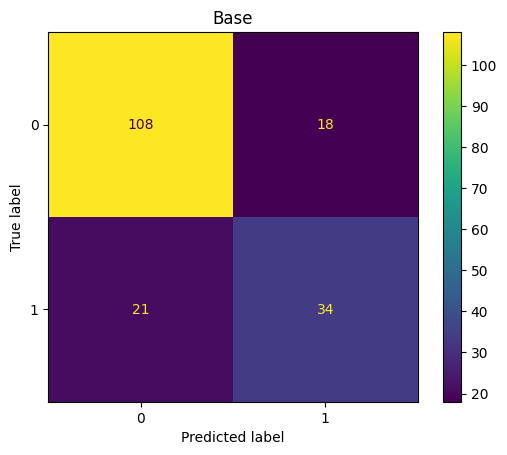

<Figure size 1000x800 with 0 Axes>

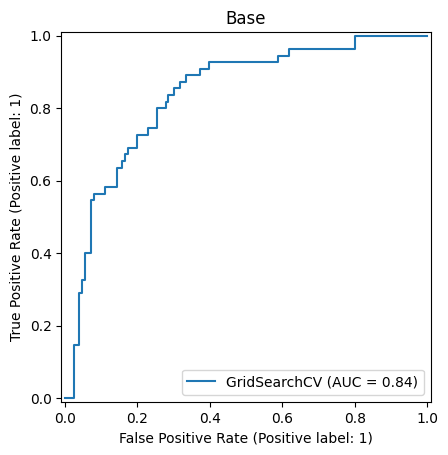

<Figure size 1000x800 with 0 Axes>

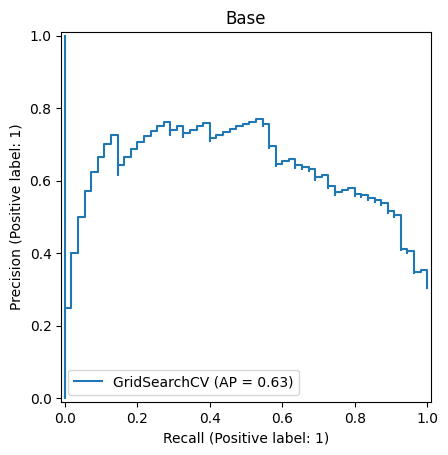

{'max_depth': np.int64(9), 'n_estimators': np.int64(18)}


<Figure size 1000x800 with 0 Axes>

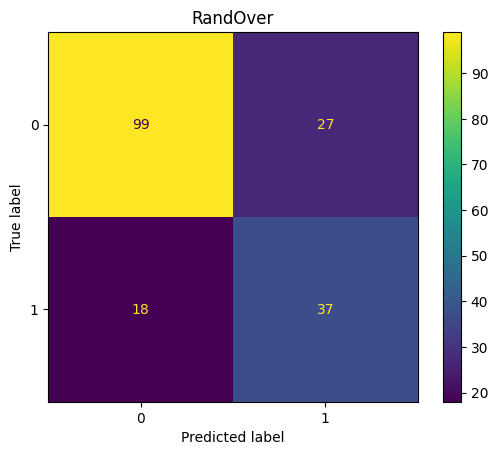

<Figure size 1000x800 with 0 Axes>

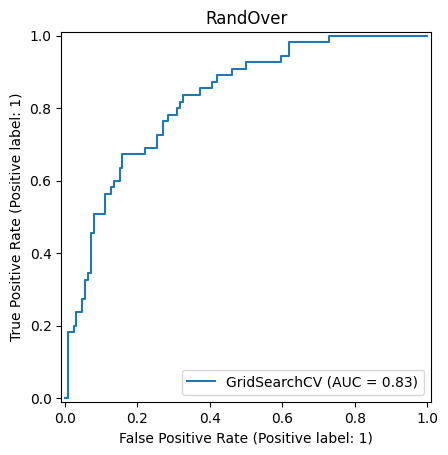

<Figure size 1000x800 with 0 Axes>

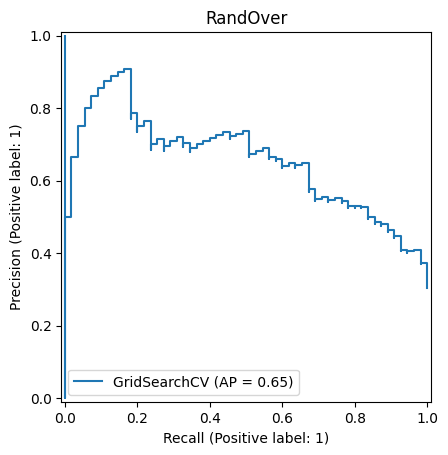

{'max_depth': np.int64(4), 'n_estimators': np.int64(17)}


<Figure size 1000x800 with 0 Axes>

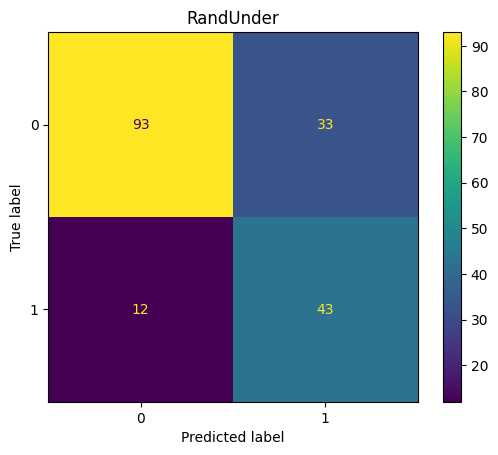

<Figure size 1000x800 with 0 Axes>

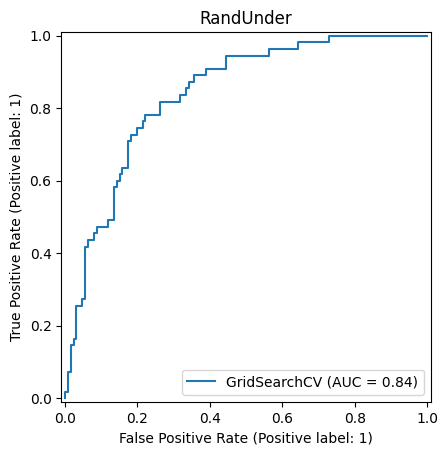

<Figure size 1000x800 with 0 Axes>

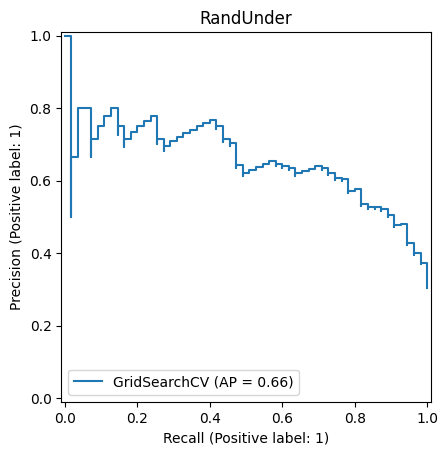

{'max_depth': np.int64(8), 'n_estimators': np.int64(17)}


<Figure size 1000x800 with 0 Axes>

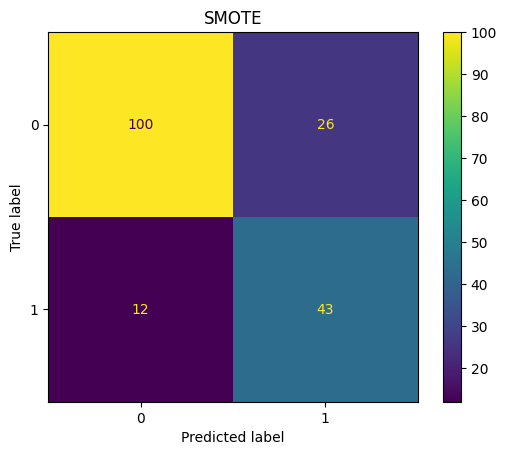

<Figure size 1000x800 with 0 Axes>

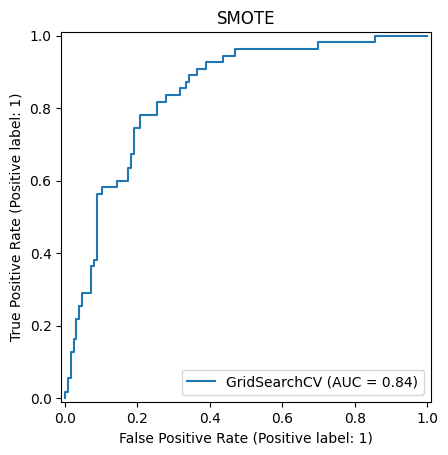

<Figure size 1000x800 with 0 Axes>

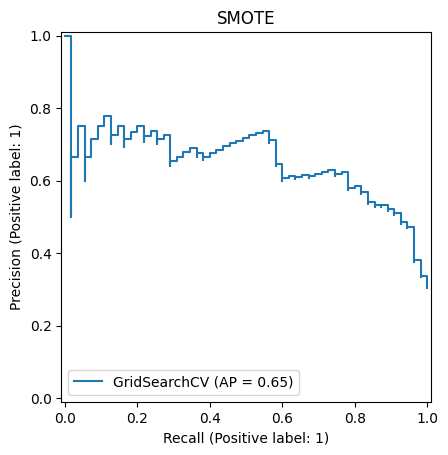

{'max_depth': np.int64(5), 'n_estimators': np.int64(16)}


<Figure size 1000x800 with 0 Axes>

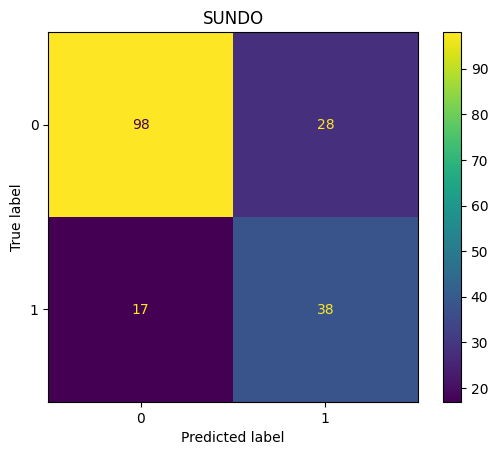

<Figure size 1000x800 with 0 Axes>

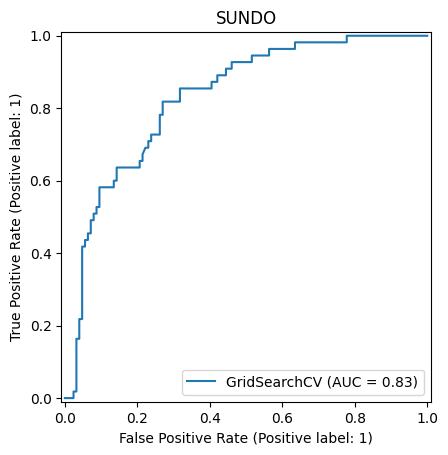

<Figure size 1000x800 with 0 Axes>

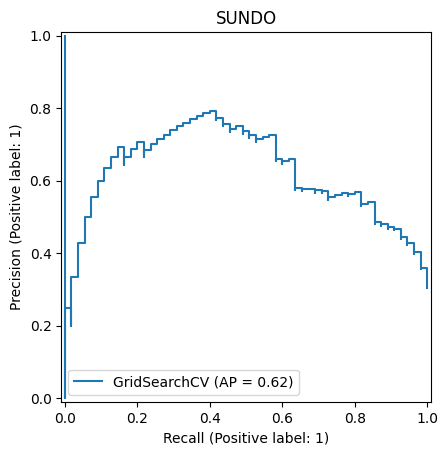

{'max_depth': np.int64(6), 'n_estimators': np.int64(16)}


<Figure size 1000x800 with 0 Axes>

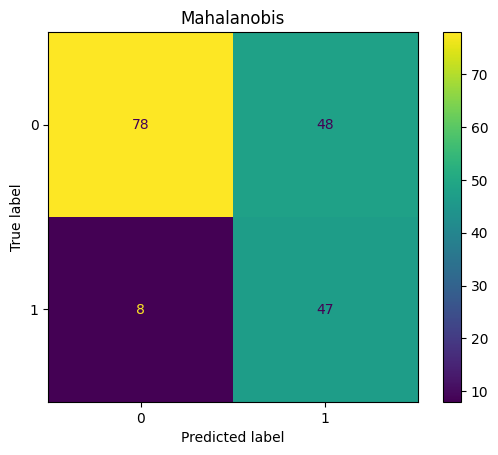

<Figure size 1000x800 with 0 Axes>

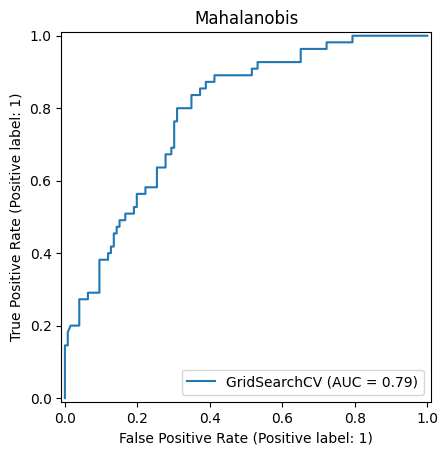

<Figure size 1000x800 with 0 Axes>

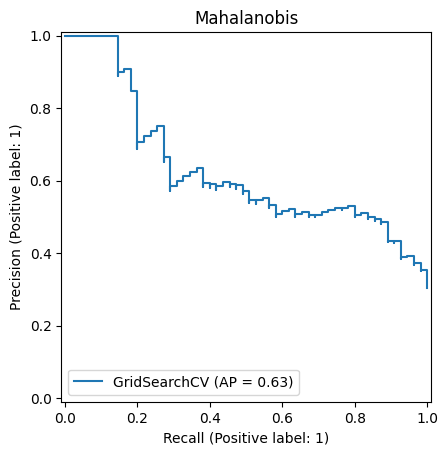

{'max_depth': np.int64(3), 'n_estimators': np.int64(16)}


<Figure size 1000x800 with 0 Axes>

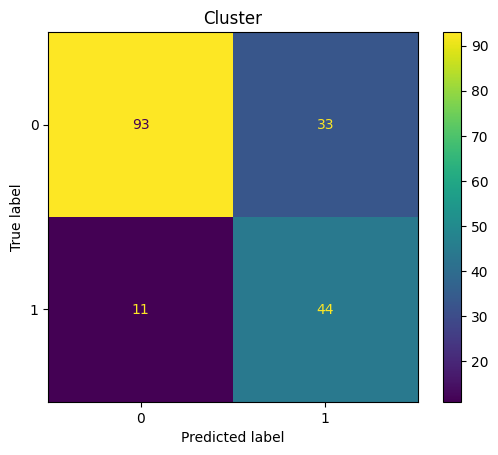

<Figure size 1000x800 with 0 Axes>

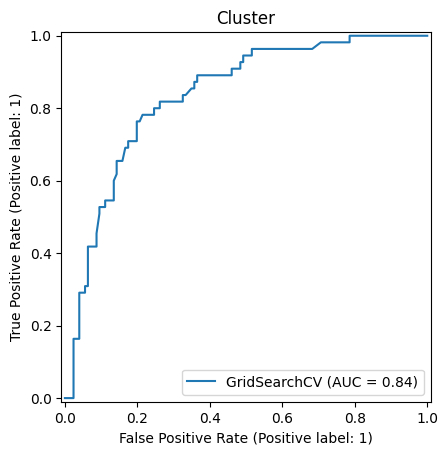

<Figure size 1000x800 with 0 Axes>

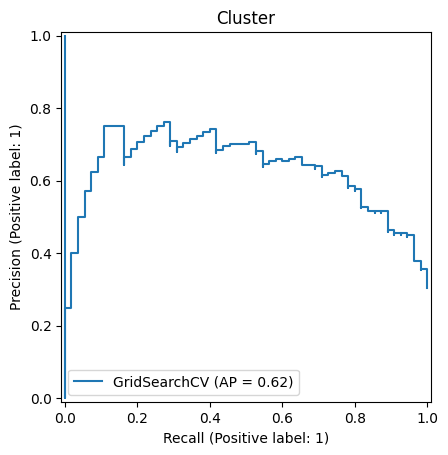

{'max_depth': np.int64(1), 'n_estimators': np.int64(15)}


<Figure size 1000x800 with 0 Axes>

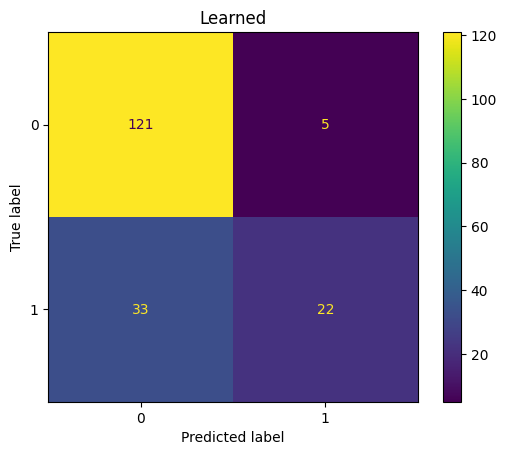

<Figure size 1000x800 with 0 Axes>

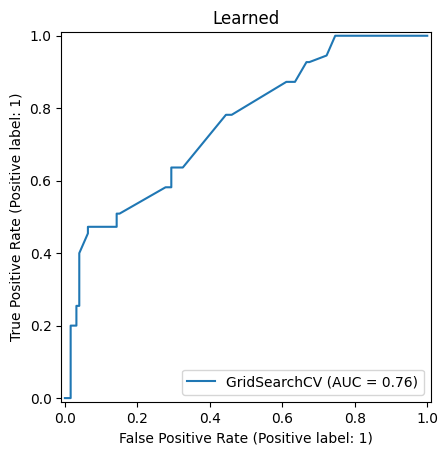

<Figure size 1000x800 with 0 Axes>

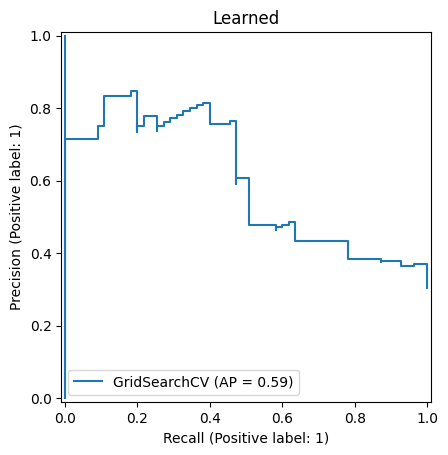

In [18]:
# Start with a random forest.

forest_metrics = pd.DataFrame(index=['Base', 'RandOver', 'RandUnder', 'SMOTE', 'SUNDO', 'Mahalanobis', 'Cluster', 'Learned'],
                             columns=['F2-Score', 'AUC'])

params = {'max_depth':np.arange(1, 10), 'n_estimators':np.arange(1,20)}

for key, value in training_sets.items():
    model = GridSearchCV(RandomForestClassifier(criterion='entropy', random_state=42), params, cv=10, scoring='roc_auc')
    scaler = MinMaxScaler()

    if key == 'Learned':
        model.fit(value['X'], value['y'])
        print(model.best_params_)
        X_mean = np.mean(X_train, axis=0)
        X_std = np.std(X_train, axis=0)
        X_std[X_std == 0] = 1  # Avoid division by zero
        X_test_scaled = (X_test - X_mean) / X_std
    else:
        model.fit(scaler.fit_transform(value['X']), value['y'])
        print(model.best_params_)
        X_test_scaled = scaler.transform(X_test)

    y_test_pred = model.predict(X_test_scaled)

    forest_metrics.at[key, 'F2-Score'] = fbeta_score(y_test, y_test_pred, beta = 2)
    forest_metrics.at[key, 'AUC'] = roc_auc_score(y_test, y_test_pred)

    plt.figure(figsize=(10, 8))
    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
    plt.title(key)
    plt.savefig(f'final-pima-{key}-forest-conf.png');
    plt.show()
    plt.figure(figsize=(10, 8))
    RocCurveDisplay.from_estimator(model, X_test_scaled, y_test)
    plt.title(key)
    plt.savefig(f'final-pima-{key}-forest-roc.png');
    plt.show()
    plt.figure(figsize=(10, 8))
    PrecisionRecallDisplay.from_estimator(model, X_test_scaled, y_test)
    plt.title(key)
    plt.savefig(f'final-pima-{key}-forest-pr.png');
    plt.show()

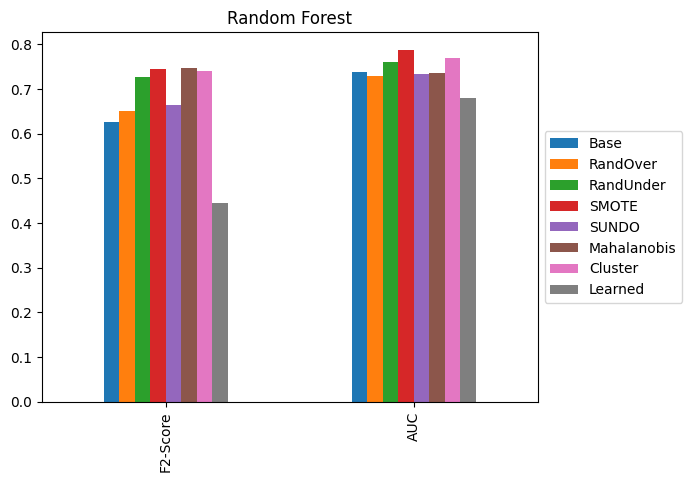

,F2-Score,AUC
Base,0.625,0.737662
RandOver,0.651408,0.729221
RandUnder,0.726351,0.759957
SMOTE,0.743945,0.787734
SUNDO,0.664336,0.734343
Mahalanobis,0.746032,0.736797
Cluster,0.740741,0.769048
Learned,0.445344,0.680159


In [19]:
forest_metrics.T.plot(kind="bar")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Random Forest');
plt.savefig('final-pima-forest-metrics.png', bbox_inches = 'tight')
plt.show()
forest_metrics

### Moving on to logistic regression.

Resampler: Base


<Figure size 1000x800 with 0 Axes>

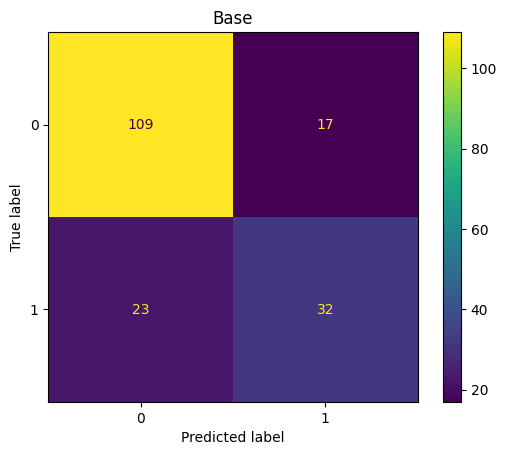

<Figure size 1000x800 with 0 Axes>

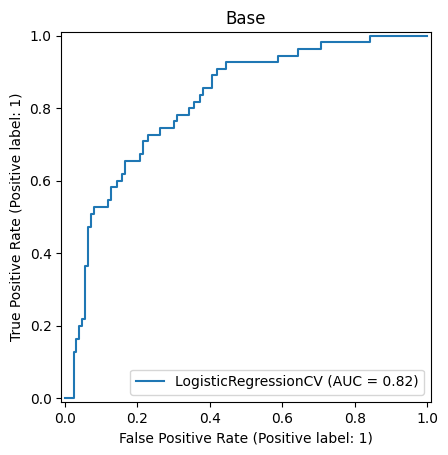

<Figure size 1000x800 with 0 Axes>

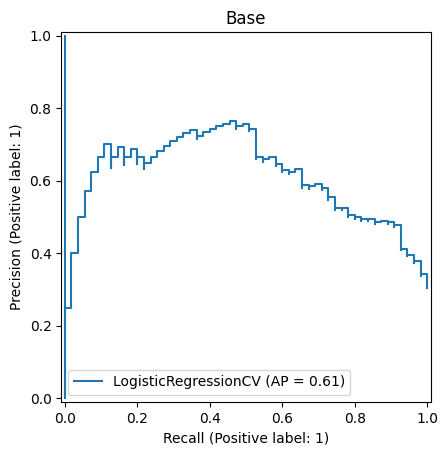

Resampler: RandOver


<Figure size 1000x800 with 0 Axes>

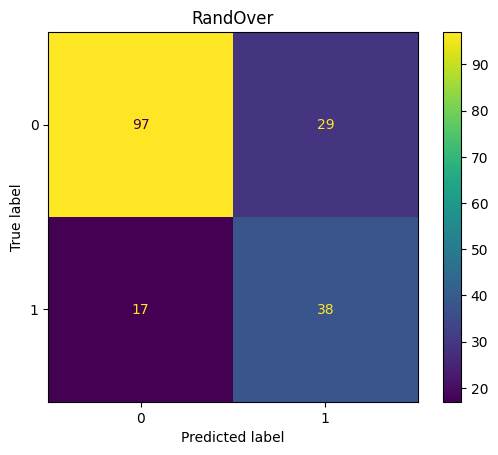

<Figure size 1000x800 with 0 Axes>

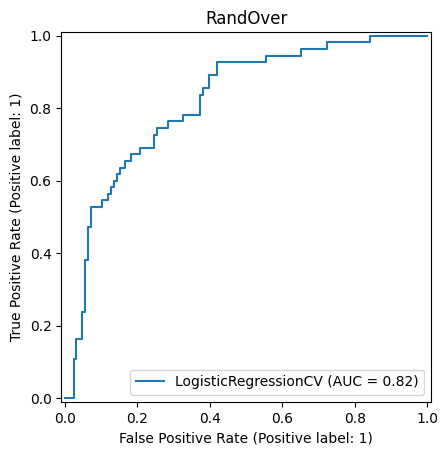

<Figure size 1000x800 with 0 Axes>

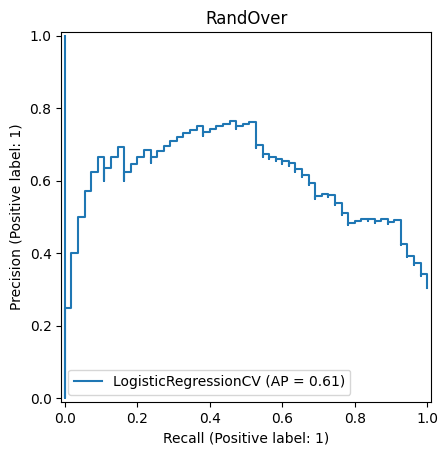

Resampler: RandUnder


<Figure size 1000x800 with 0 Axes>

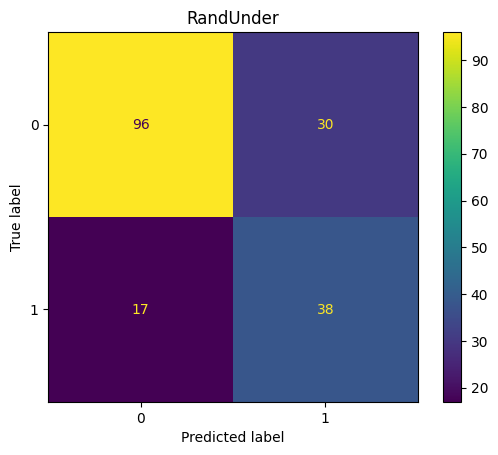

<Figure size 1000x800 with 0 Axes>

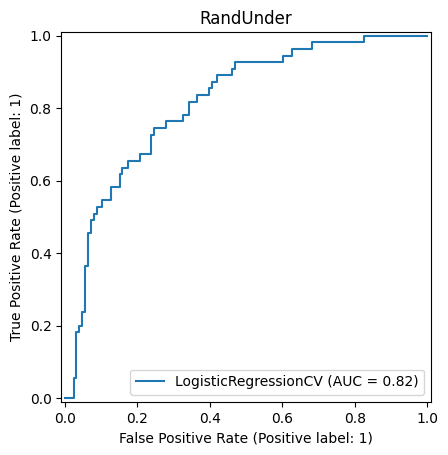

<Figure size 1000x800 with 0 Axes>

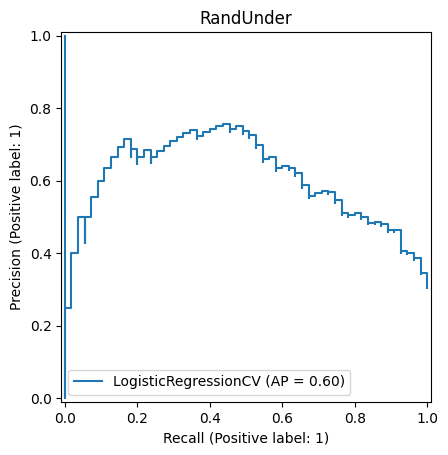

Resampler: SMOTE


<Figure size 1000x800 with 0 Axes>

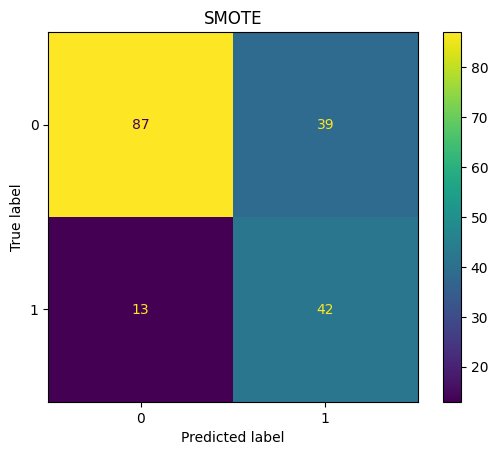

<Figure size 1000x800 with 0 Axes>

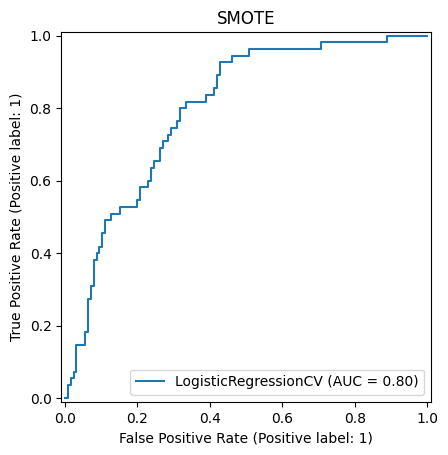

<Figure size 1000x800 with 0 Axes>

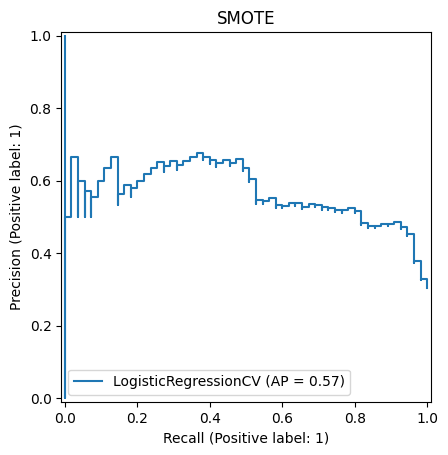

Resampler: SUNDO


<Figure size 1000x800 with 0 Axes>

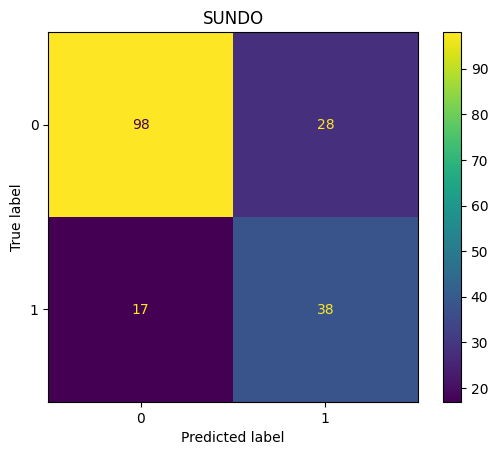

<Figure size 1000x800 with 0 Axes>

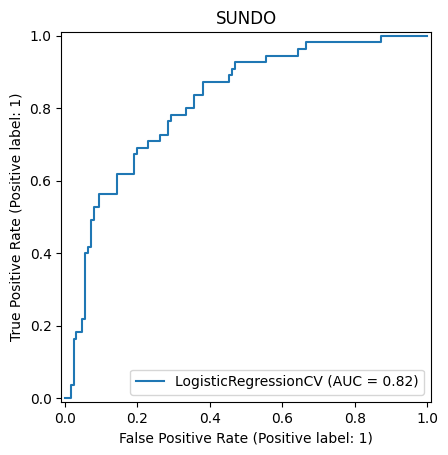

<Figure size 1000x800 with 0 Axes>

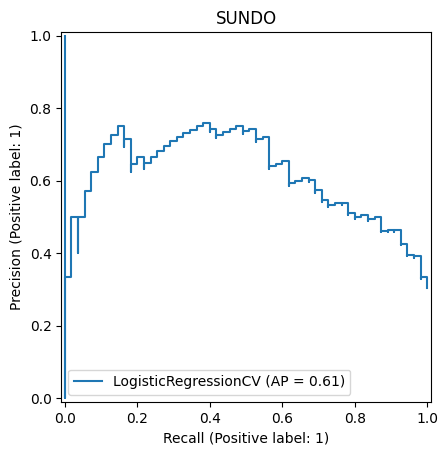

Resampler: Mahalanobis


<Figure size 1000x800 with 0 Axes>

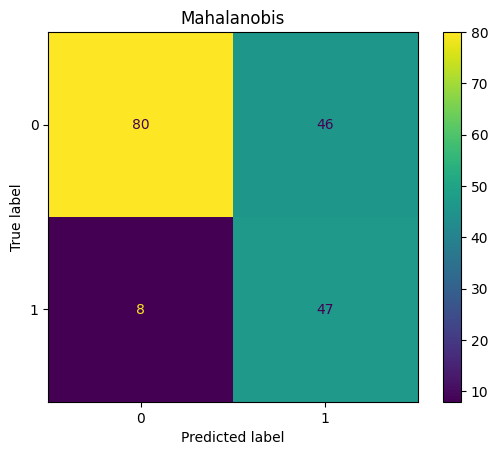

<Figure size 1000x800 with 0 Axes>

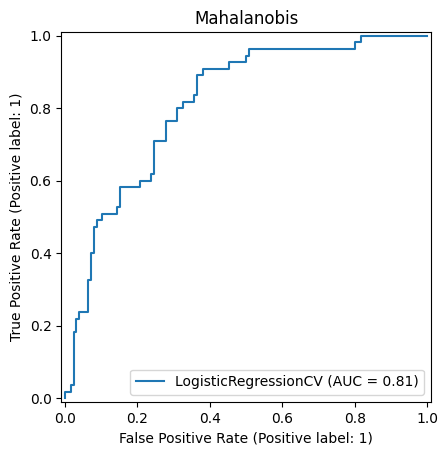

<Figure size 1000x800 with 0 Axes>

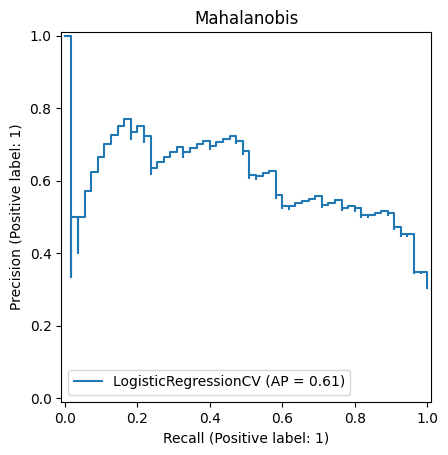

Resampler: Cluster


<Figure size 1000x800 with 0 Axes>

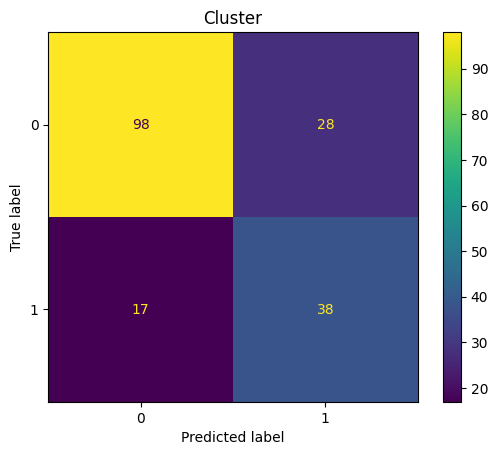

<Figure size 1000x800 with 0 Axes>

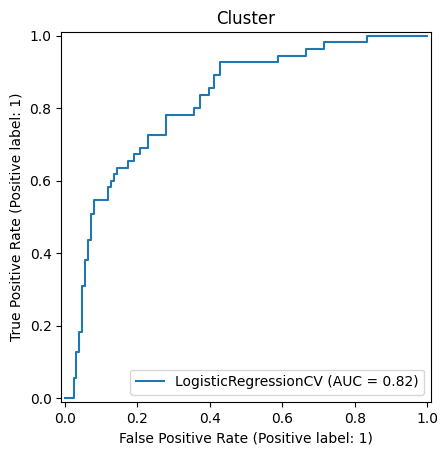

<Figure size 1000x800 with 0 Axes>

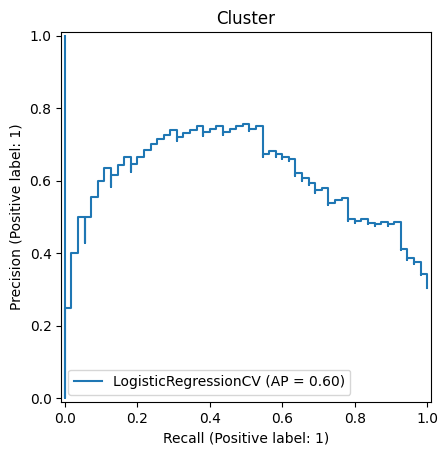

Resampler: Learned


<Figure size 1000x800 with 0 Axes>

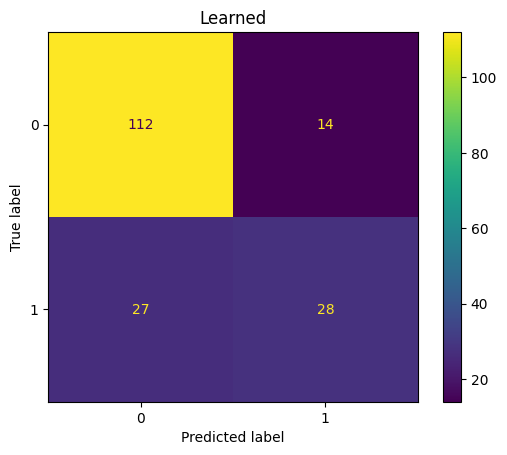

<Figure size 1000x800 with 0 Axes>

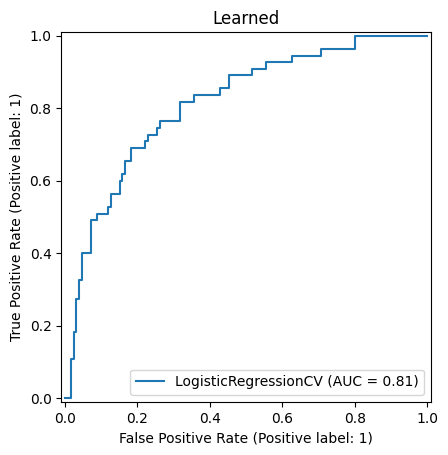

<Figure size 1000x800 with 0 Axes>

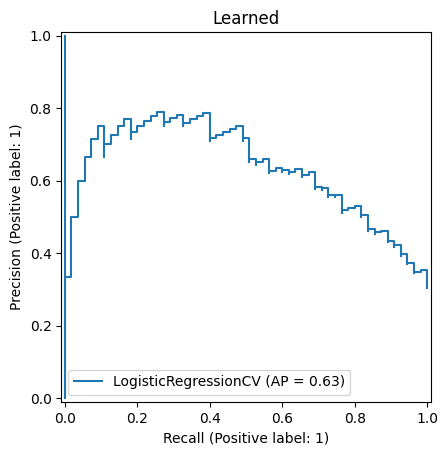

In [20]:
regress_metrics = pd.DataFrame(index=['Base', 'RandOver', 'RandUnder', 'SMOTE', 'SUNDO', 'Mahalanobis', 'Cluster', 'Learned'],
                             columns=['F2-Score', 'AUC'])
for key, value in training_sets.items():
    model = LogisticRegressionCV(random_state=42)
    scaler = MinMaxScaler()

    if key == 'Learned':
        model.fit(value['X'], value['y'])
        X_mean = np.mean(X_train, axis=0)
        X_std = np.std(X_train, axis=0)
        X_std[X_std == 0] = 1  # Avoid division by zero
        X_test_scaled = (X_test - X_mean) / X_std
    else:
        model.fit(scaler.fit_transform(value['X']), value['y'])
        X_test_scaled = scaler.transform(X_test)

    y_test_pred = model.predict(X_test_scaled)

    regress_metrics.at[key, 'F2-Score'] = fbeta_score(y_test, y_test_pred, beta = 2)
    regress_metrics.at[key, 'AUC'] = roc_auc_score(y_test, y_test_pred)

    print(f"Resampler: {key}")
    plt.figure(figsize=(10, 8))
    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
    plt.title(key)
    plt.savefig(f'final-pima-{key}-regress-conf.png');
    plt.show()
    plt.figure(figsize=(10, 8))
    RocCurveDisplay.from_estimator(model, X_test_scaled, y_test)
    plt.title(key)
    plt.savefig(f'final-pima-{key}-regress-roc.png');
    plt.show()
    plt.figure(figsize=(10, 8))
    PrecisionRecallDisplay.from_estimator(model, X_test_scaled, y_test)
    plt.title(key)
    plt.savefig(f'final-pima-{key}-regress-pr.png');
    plt.show()

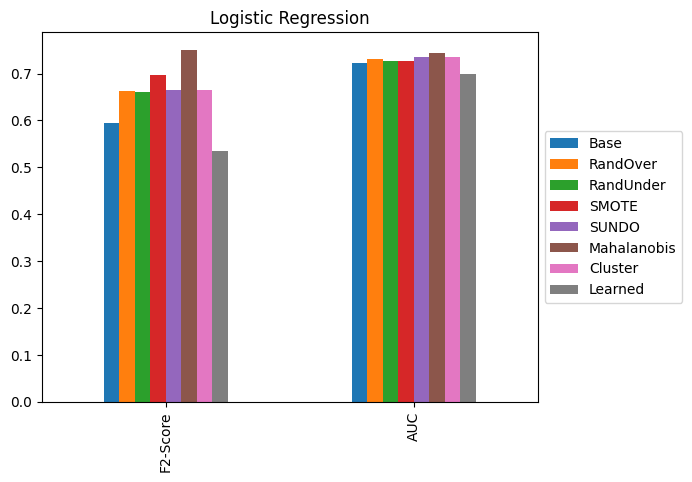

,F2-Score,AUC
Base,0.594796,0.723449
RandOver,0.662021,0.730375
RandUnder,0.659722,0.726407
SMOTE,0.697674,0.727056
SUNDO,0.664336,0.734343
Mahalanobis,0.750799,0.744733
Cluster,0.664336,0.734343
Learned,0.534351,0.69899


In [21]:
regress_metrics.T.plot(kind="bar")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Logistic Regression');
plt.savefig('final-pima-regress-metrics.png', bbox_inches = 'tight')
plt.show()
regress_metrics

### A Multi-Layer Perceptron

Resampler: Base


/opt/anaconda3/envs/dat490/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<Figure size 1000x800 with 0 Axes>

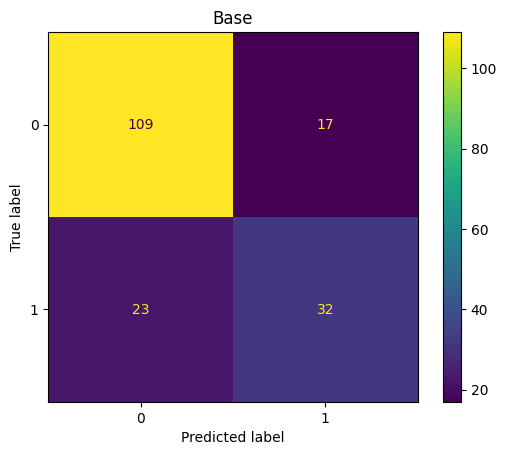

<Figure size 1000x800 with 0 Axes>

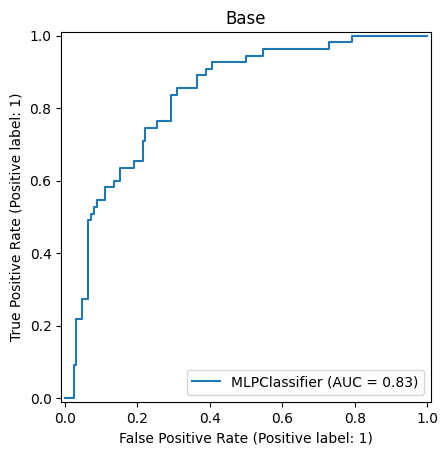

<Figure size 1000x800 with 0 Axes>

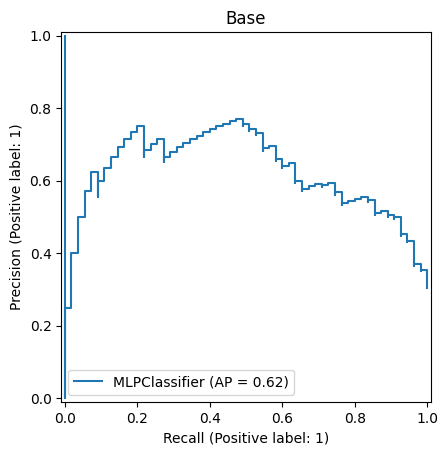

Resampler: RandOver


/opt/anaconda3/envs/dat490/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<Figure size 1000x800 with 0 Axes>

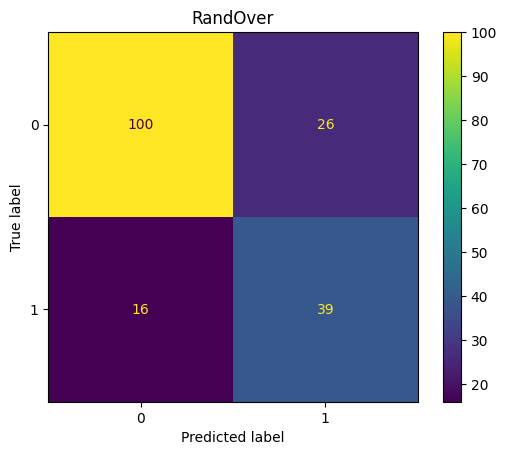

<Figure size 1000x800 with 0 Axes>

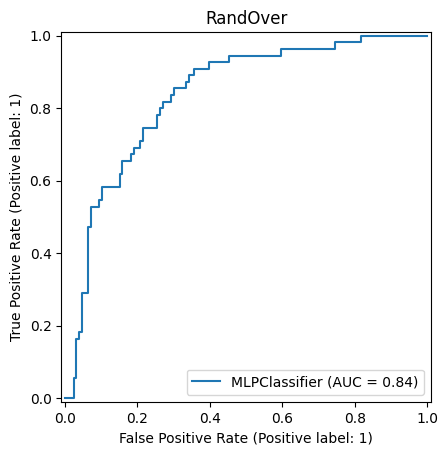

<Figure size 1000x800 with 0 Axes>

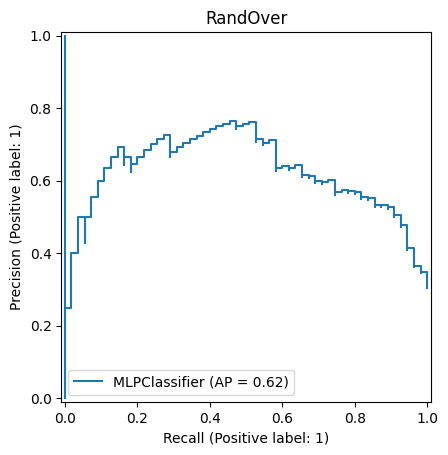

Resampler: RandUnder


/opt/anaconda3/envs/dat490/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<Figure size 1000x800 with 0 Axes>

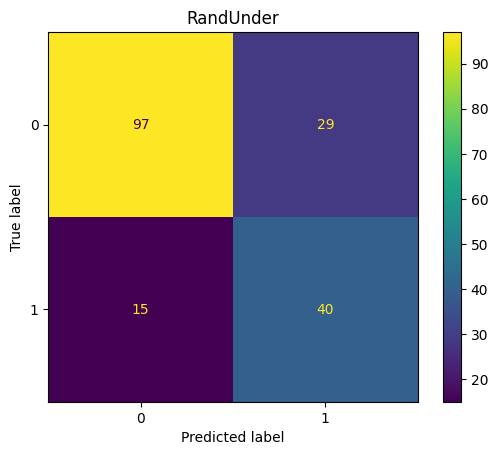

<Figure size 1000x800 with 0 Axes>

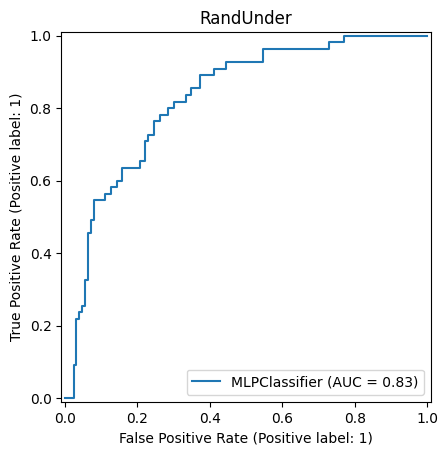

<Figure size 1000x800 with 0 Axes>

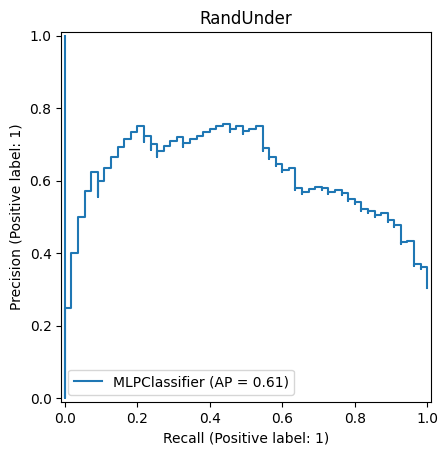

Resampler: SMOTE


/opt/anaconda3/envs/dat490/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<Figure size 1000x800 with 0 Axes>

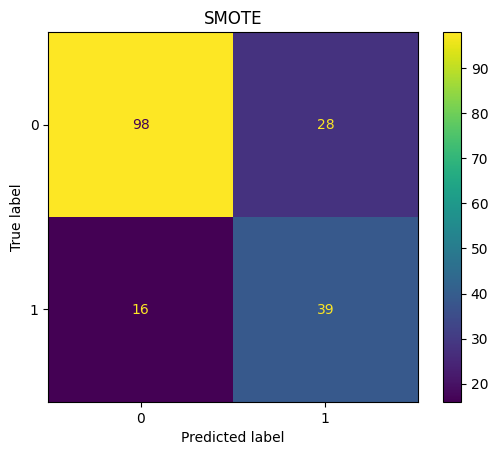

<Figure size 1000x800 with 0 Axes>

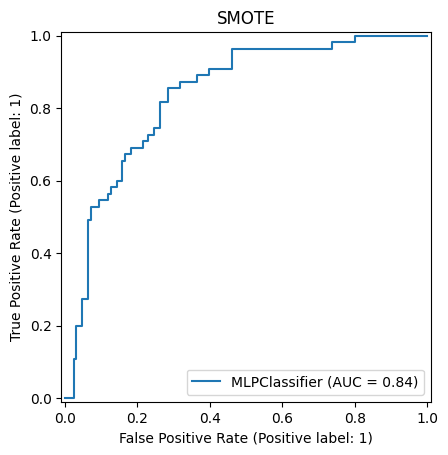

<Figure size 1000x800 with 0 Axes>

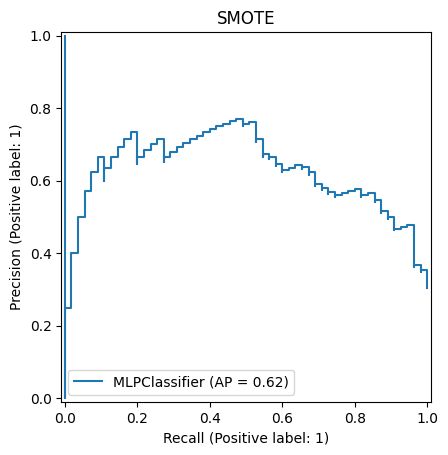

Resampler: SUNDO


/opt/anaconda3/envs/dat490/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<Figure size 1000x800 with 0 Axes>

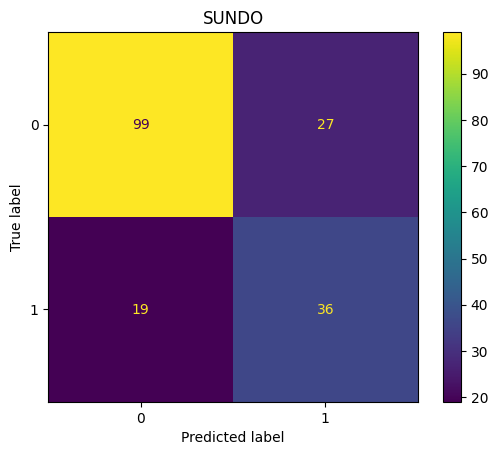

<Figure size 1000x800 with 0 Axes>

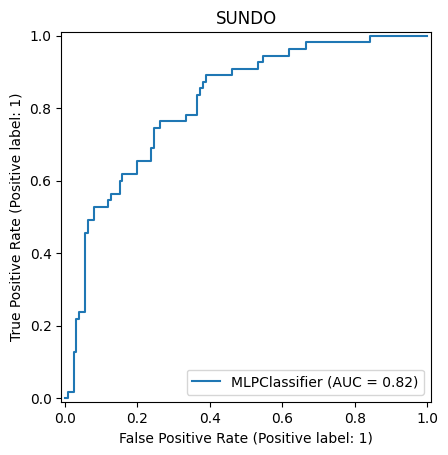

<Figure size 1000x800 with 0 Axes>

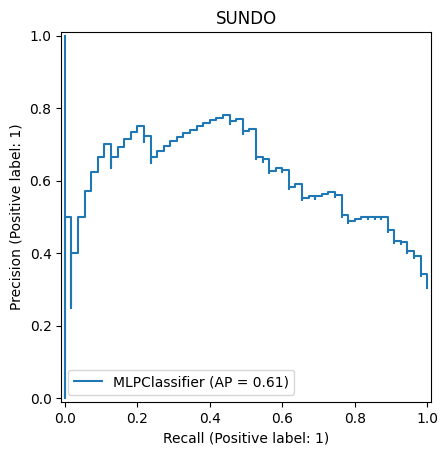

Resampler: Mahalanobis


/opt/anaconda3/envs/dat490/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<Figure size 1000x800 with 0 Axes>

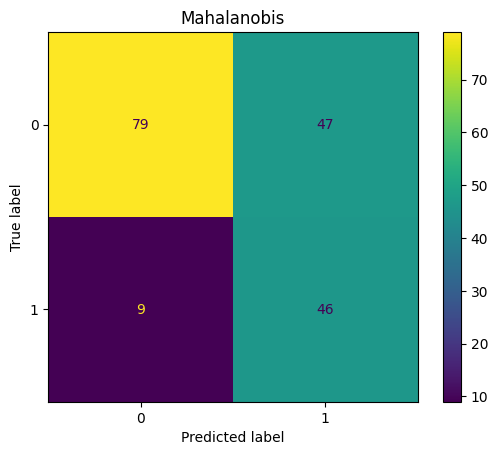

<Figure size 1000x800 with 0 Axes>

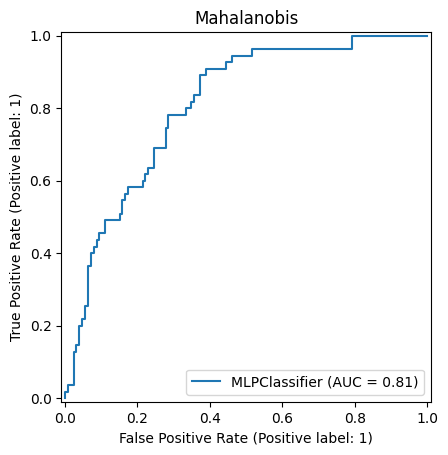

<Figure size 1000x800 with 0 Axes>

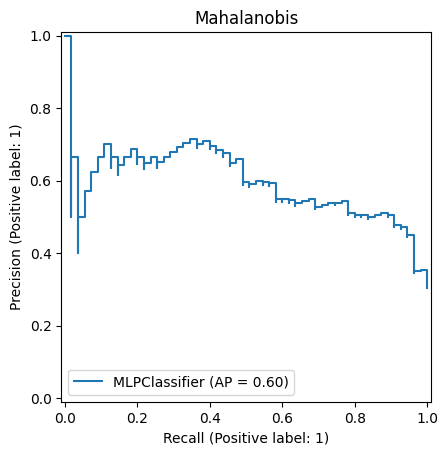

Resampler: Cluster


/opt/anaconda3/envs/dat490/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<Figure size 1000x800 with 0 Axes>

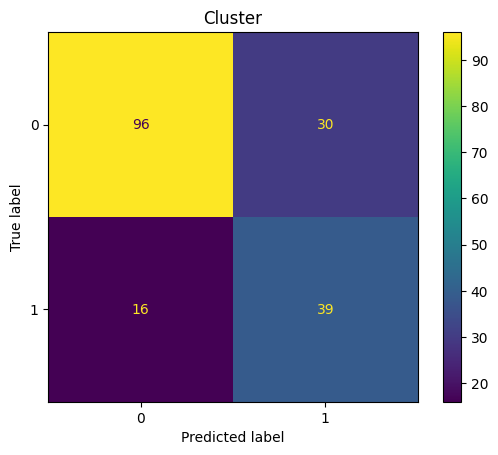

<Figure size 1000x800 with 0 Axes>

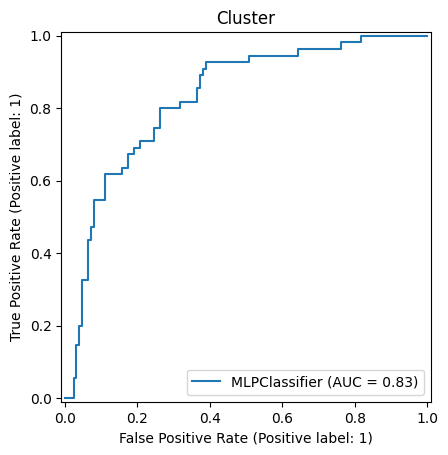

<Figure size 1000x800 with 0 Axes>

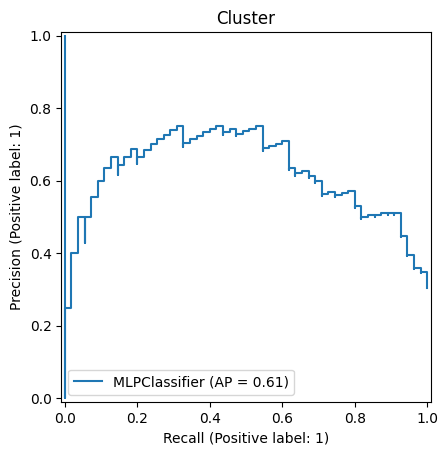

Resampler: Learned


/opt/anaconda3/envs/dat490/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


<Figure size 1000x800 with 0 Axes>

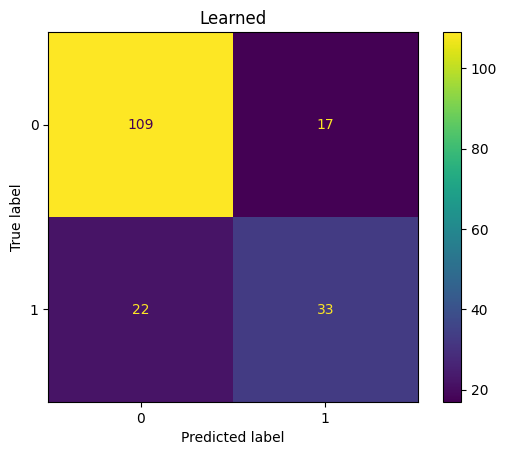

<Figure size 1000x800 with 0 Axes>

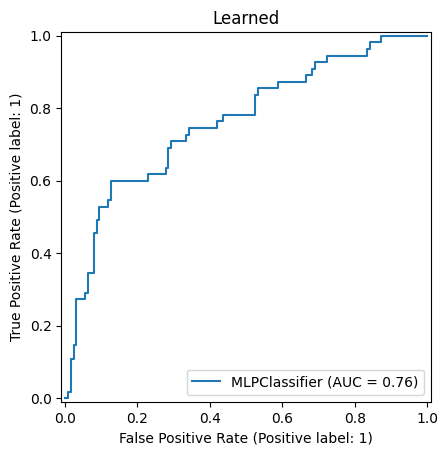

<Figure size 1000x800 with 0 Axes>

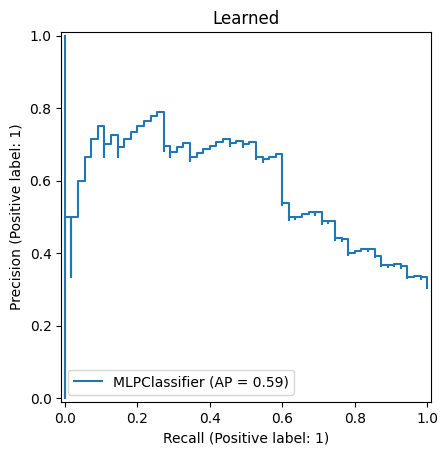

In [22]:
neural_metrics = pd.DataFrame(index=['Base', 'RandOver', 'RandUnder', 'SMOTE', 'SUNDO', 'Mahalanobis', 'Cluster', 'Learned'],
                             columns=['F2-Score', 'AUC'])
for key, value in training_sets.items():
    model = MLPClassifier(random_state=42)
    scaler = MinMaxScaler()

    if key == 'Learned':
        model.fit(value['X'], value['y'])
        X_mean = np.mean(X_train, axis=0)
        X_std = np.std(X_train, axis=0)
        X_std[X_std == 0] = 1  # Avoid division by zero
        X_test_scaled = (X_test - X_mean) / X_std
    else:
        model.fit(scaler.fit_transform(value['X']), value['y'])
        X_test_scaled = scaler.transform(X_test)

    y_test_pred = model.predict(X_test_scaled)

    neural_metrics.at[key, 'F2-Score'] = fbeta_score(y_test, y_test_pred, beta = 2)
    neural_metrics.at[key, 'AUC'] = roc_auc_score(y_test, y_test_pred)

    print(f"Resampler: {key}")
    fig = plt.figure(figsize=(10, 8))
    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
    plt.title(key)
    plt.savefig(f'final-pima-{key}-neural-conf.png');
    plt.show()
    plt.figure(figsize=(10, 8))
    RocCurveDisplay.from_estimator(model, X_test_scaled, y_test)
    plt.title(key)
    plt.savefig(f'final-pima-{key}-neural-roc.png');
    plt.show()
    plt.figure(figsize=(10, 8))
    PrecisionRecallDisplay.from_estimator(model, X_test_scaled, y_test)
    plt.title(key)
    plt.savefig(f'final-pima-{key}-neural-pr.png');
    plt.show()

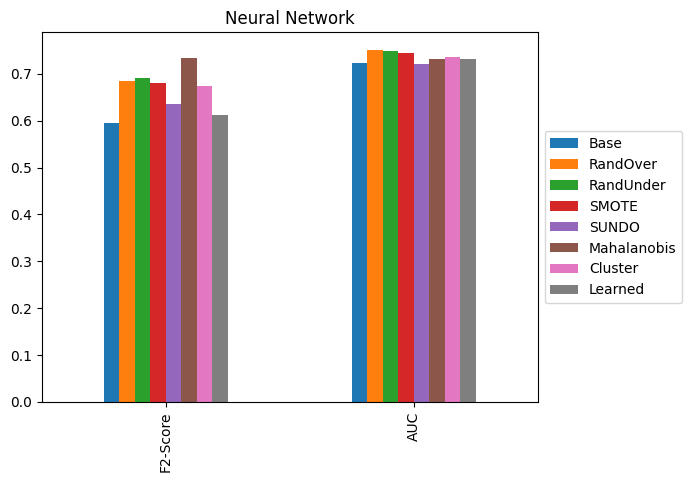

,F2-Score,AUC
Base,0.594796,0.723449
RandOver,0.684211,0.751371
RandUnder,0.692042,0.748557
SMOTE,0.679443,0.743434
SUNDO,0.636042,0.72013
Mahalanobis,0.734824,0.731674
Cluster,0.67474,0.735498
Learned,0.611111,0.73254


In [23]:
neural_metrics.T.plot(kind="bar")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Neural Network');
plt.savefig('final-pima-neural-metrics.png', bbox_inches = 'tight')
plt.show()
neural_metrics

{'n_neighbors': np.int64(28)}


<Figure size 1000x800 with 0 Axes>

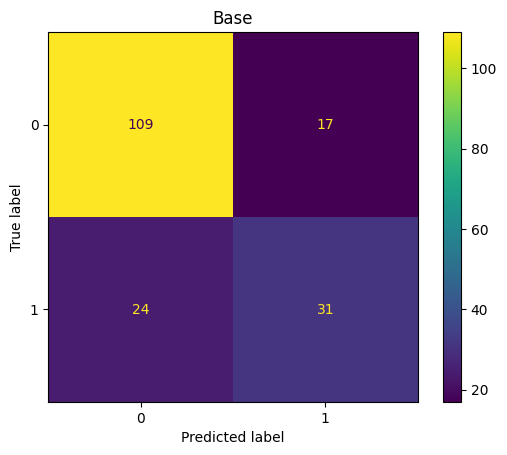

<Figure size 1000x800 with 0 Axes>

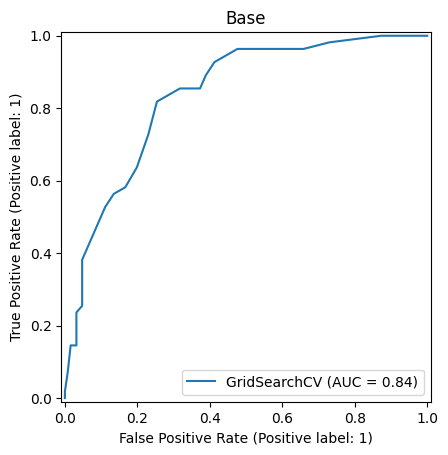

<Figure size 1000x800 with 0 Axes>

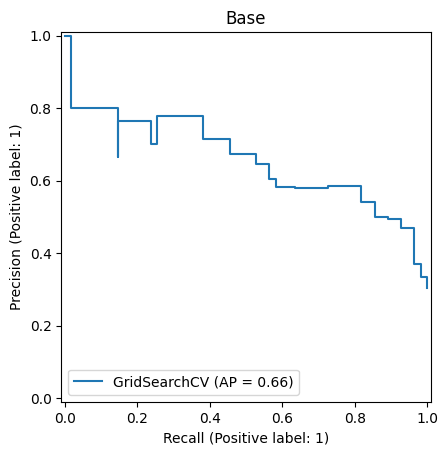

{'n_neighbors': np.int64(11)}


<Figure size 1000x800 with 0 Axes>

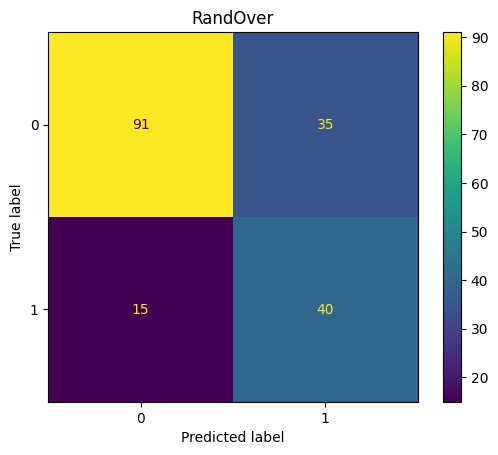

<Figure size 1000x800 with 0 Axes>

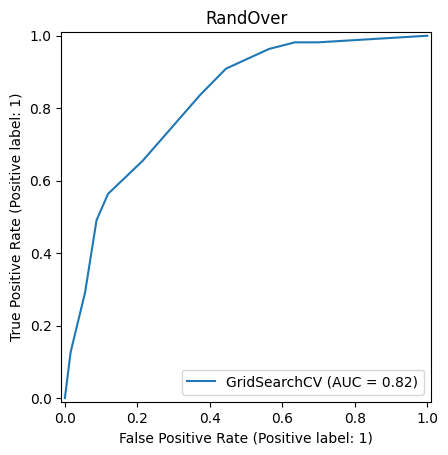

<Figure size 1000x800 with 0 Axes>

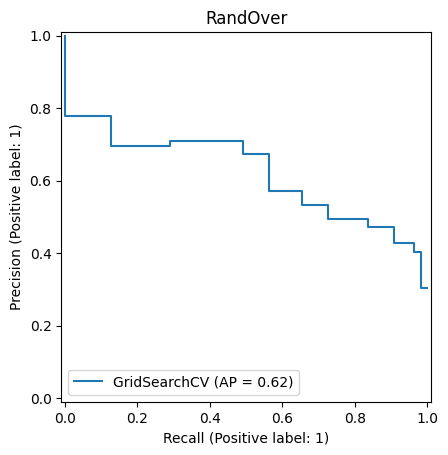

{'n_neighbors': np.int64(28)}


<Figure size 1000x800 with 0 Axes>

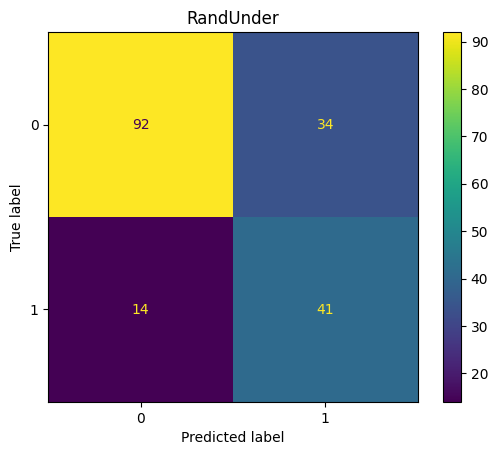

<Figure size 1000x800 with 0 Axes>

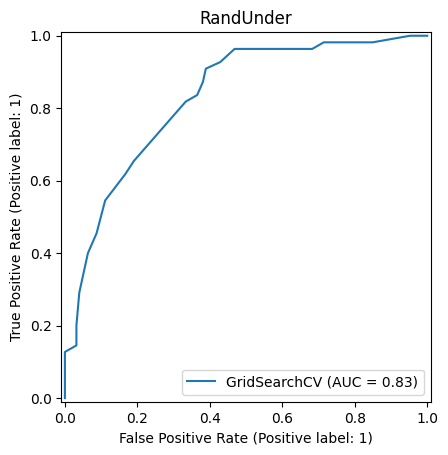

<Figure size 1000x800 with 0 Axes>

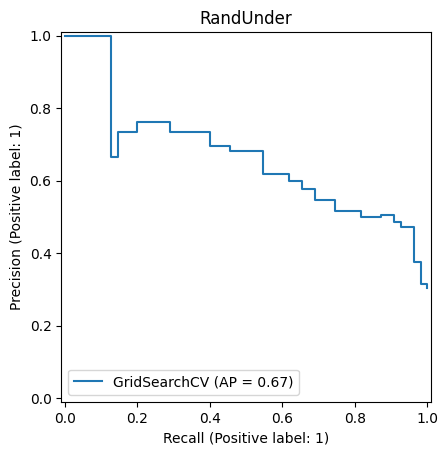

{'n_neighbors': np.int64(5)}


<Figure size 1000x800 with 0 Axes>

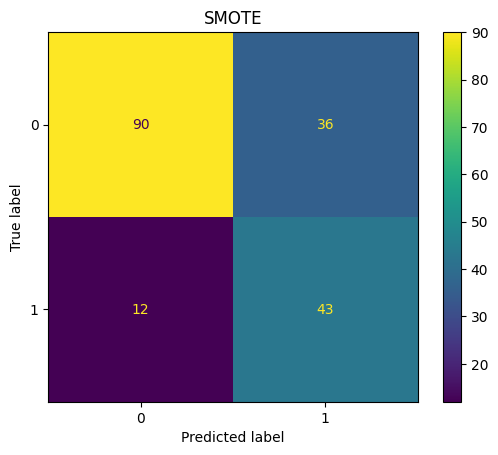

<Figure size 1000x800 with 0 Axes>

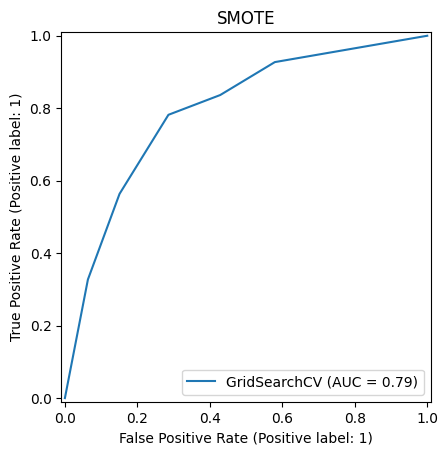

<Figure size 1000x800 with 0 Axes>

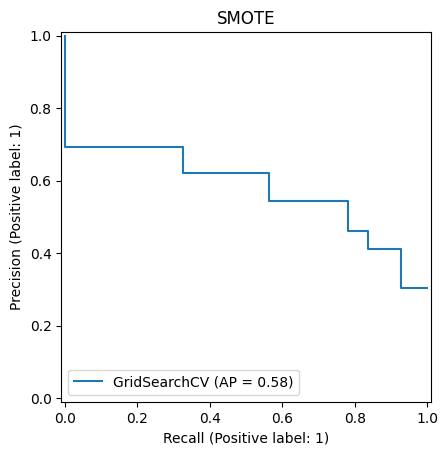

{'n_neighbors': np.int64(29)}


<Figure size 1000x800 with 0 Axes>

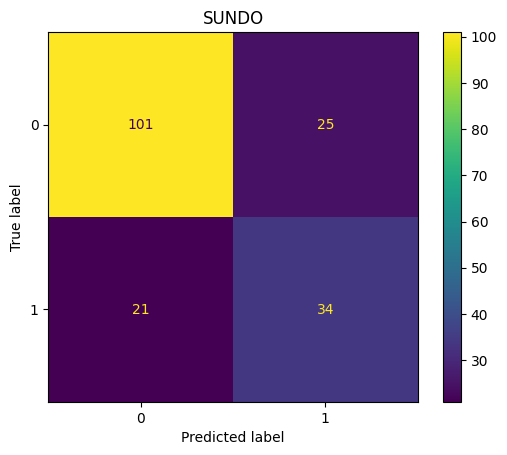

<Figure size 1000x800 with 0 Axes>

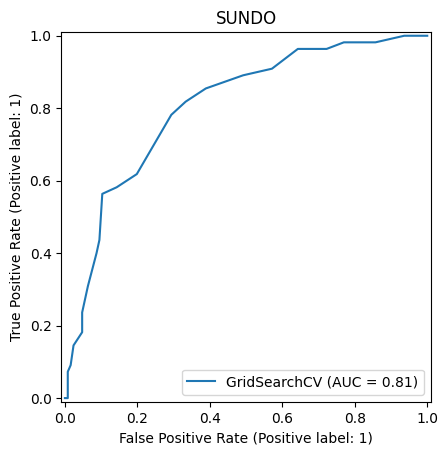

<Figure size 1000x800 with 0 Axes>

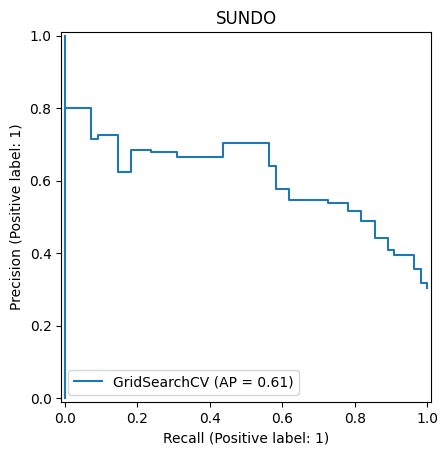

{'n_neighbors': np.int64(25)}


<Figure size 1000x800 with 0 Axes>

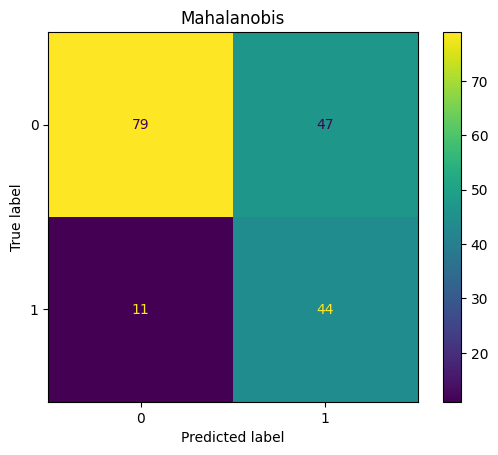

<Figure size 1000x800 with 0 Axes>

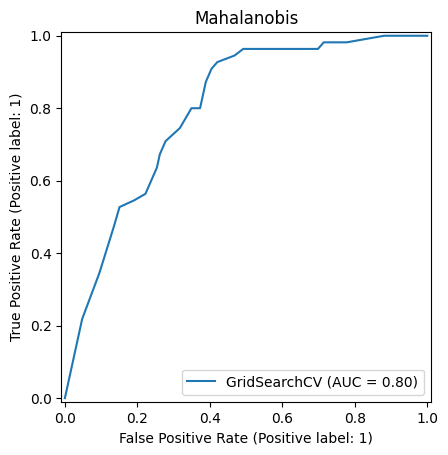

<Figure size 1000x800 with 0 Axes>

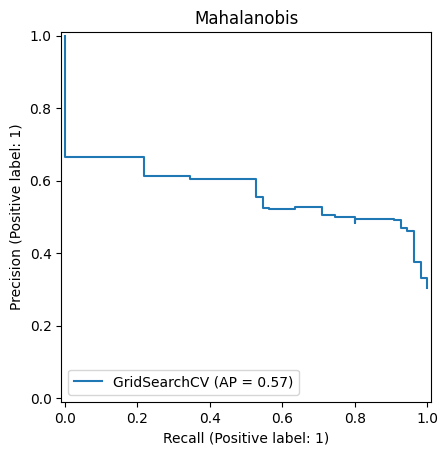

{'n_neighbors': np.int64(20)}


<Figure size 1000x800 with 0 Axes>

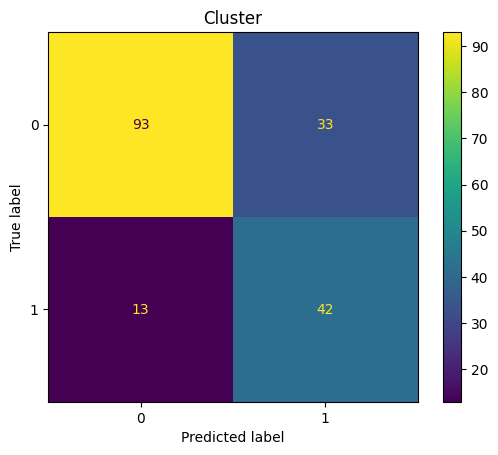

<Figure size 1000x800 with 0 Axes>

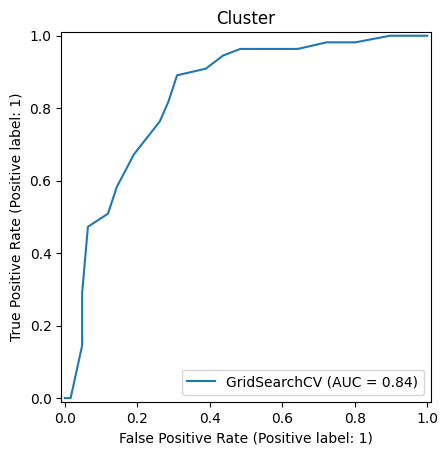

<Figure size 1000x800 with 0 Axes>

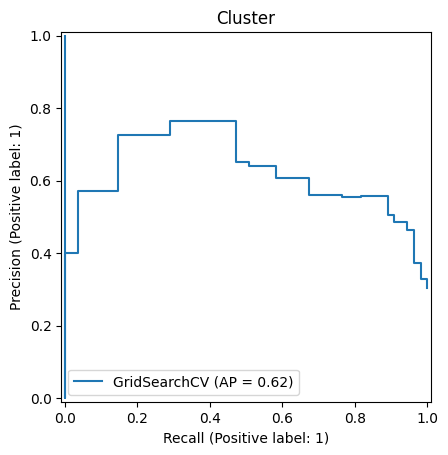

{'n_neighbors': np.int64(3)}


<Figure size 1000x800 with 0 Axes>

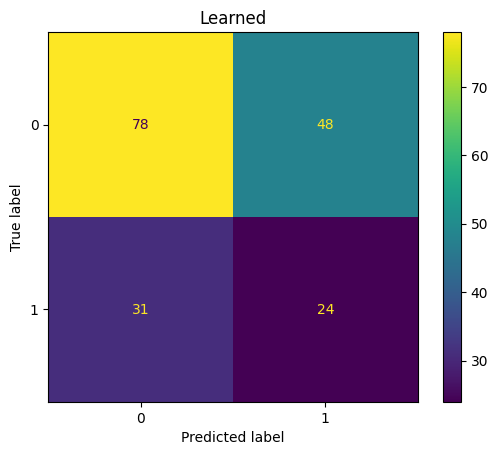

<Figure size 1000x800 with 0 Axes>

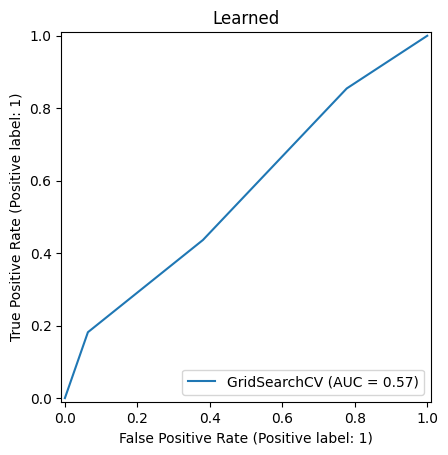

<Figure size 1000x800 with 0 Axes>

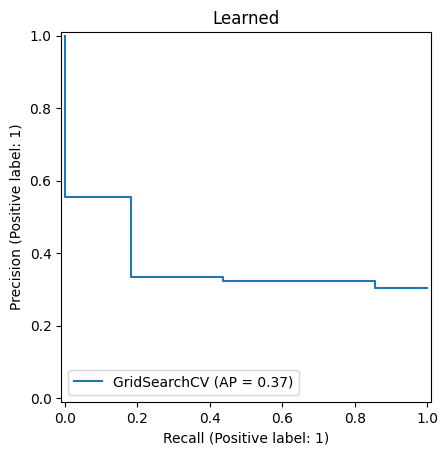

In [24]:
neighbor_metrics = pd.DataFrame(index=['Base', 'RandOver', 'RandUnder', 'SMOTE', 'SUNDO', 'Mahalanobis', 'Cluster', 'Learned'],
                             columns=['F2-Score', 'AUC'])

params = {'n_neighbors':np.arange(3, 30)}

for key, value in training_sets.items():
    model = GridSearchCV(KNeighborsClassifier(), params, cv=10, scoring='roc_auc')
    scaler = MinMaxScaler()

    if key == 'Learned':
        model.fit(value['X'], value['y'])
        print(model.best_params_)
        X_mean = np.mean(X_train, axis=0)
        X_std = np.std(X_train, axis=0)
        X_std[X_std == 0] = 1  # Avoid division by zero
        X_test_scaled = (X_test - X_mean) / X_std
    else:
        model.fit(scaler.fit_transform(value['X']), value['y'])
        print(model.best_params_)
        X_test_scaled = scaler.transform(X_test)

    y_test_pred = model.predict(X_test_scaled)

    neighbor_metrics.at[key, 'F2-Score'] = fbeta_score(y_test, y_test_pred, beta = 2)
    neighbor_metrics.at[key, 'AUC'] = roc_auc_score(y_test, y_test_pred)

    plt.figure(figsize=(10, 8))
    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
    plt.title(key)
    plt.savefig(f'final-pima-{key}-neighbors-conf.png');
    plt.show()
    plt.figure(figsize=(10, 8))
    RocCurveDisplay.from_estimator(model, X_test_scaled, y_test)
    plt.title(key)
    plt.savefig(f'final-pima-{key}-neighbors-roc.png');
    plt.show()
    plt.figure(figsize=(10, 8))
    PrecisionRecallDisplay.from_estimator(model, X_test_scaled, y_test)
    plt.title(key)
    plt.savefig(f'final-pima-{key}-neighbors-pr.png');
    plt.show()

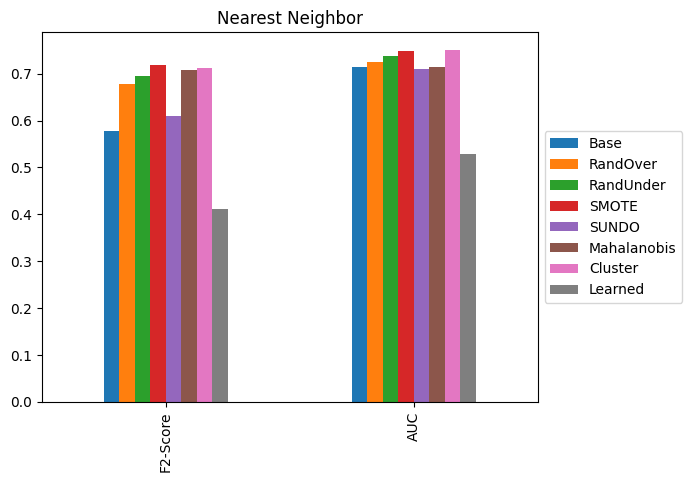

,F2-Score,AUC
Base,0.578358,0.714358
RandOver,0.677966,0.724747
RandUnder,0.694915,0.737807
SMOTE,0.719064,0.748052
SUNDO,0.609319,0.709885
Mahalanobis,0.707395,0.713492
Cluster,0.711864,0.750866
Learned,0.410959,0.527706


In [25]:
neighbor_metrics.T.plot(kind="bar")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Nearest Neighbor');
plt.savefig('final-pima-neighbor-metrics.png', bbox_inches = 'tight')
plt.show()
neighbor_metrics